# Hands-on curve fitting examples with Linear models, Neural Networks, Maximum Likelihood, Bayesian NN  

Contents:
1. Linear regression example and over-fitting mitigation via Ridge and Lasso  
2. Standard (nonlinear) neural network model 
3. Linear model with Neural Network frameworks 
4. Linear model with Tensorflow GradientTape
5. Linear model with maximum likelihood under constant variance
6. Linear model with maximum likelihood under non-constant variance
7. Neural-Network Model using a Maximum Likelihood  
8. Conditional probability distribution modeling with Tensorflow Probability 
9. Bayesian neural network via variational inference/Flipout layer
10. Bayesian neural network via Monte Carlo dropout/Dropout layer

This notebook is intended for **interactive/hands-on learning** to **increase the familiarity with the art of neural network training**. Using single-input single-output curve fitting examples with simulated data (e.g., a 100-data point baseline and a 10-data point small sample), we fit various models.  

To my knowledge, **setting up and training a neural network can be easy or difficult, depending on the context**. When it is easy, it can be trained well in any way under different versions layer-weight structures and various training parameters. When it is hard, it can take time to find a right approach to specify the layers and set the right training parameters. Sometimes it is useful to train a model over multiple sets of training parameters (i.e., train with one set, change training parameters, and train some more). Neural network weights are iteratively updated, so one can save weights at the best performance metric and train some more to see if it can be improved. 

**Tensorflow tutorials** are a great resource. Its examples, nonetheless, tend to focus on image processing examples such as [hand-written number recognition](https://www.tensorflow.org/tutorials/quickstart/beginner) and [fashion item classification](https://www.tensorflow.org/tutorials/keras/classification). For those who tend to make predictive models with numerical or categorical inputs, it appears useful to grasp how to train neural networks in the context of simple curve-fitting examples.  

Even for a simple context of curve-fitting problem, we show there are various ways one could approach. It can be handy to know various ways to tackle a problem in the face of a difficult modeling situation.  **Maximum likelihood** is often reliable when we have an explicit formula (i.e. distribution function). **Tensorflow GradientTape** lets one customize the neural network training process. **Tensorflow probability** (TFP) allows for conditional variance modeling via an arbitrary neural network. TFP also offers easy-to-use methods to implement **Bayesian neural network** specifications via **Flipout** and **Dropout layers**.   


**Remember to change model specs and experiment.**  


In [1]:
# Reference: Probabilistic Deep Learning by Durr, Sick, and Murina 
# https://www.manning.com/books/probabilistic-deep-learning 
# the main source is: https://github.com/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_03.ipynb
# and the authors' notebooks for other chapters

import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)


TFP Version 0.14.0
TF  Version 2.6.0


## 0. Data generation

Let's try a simple polynomial curve fitting example as in Chapter 1 of [Bishop's book](https://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738).   

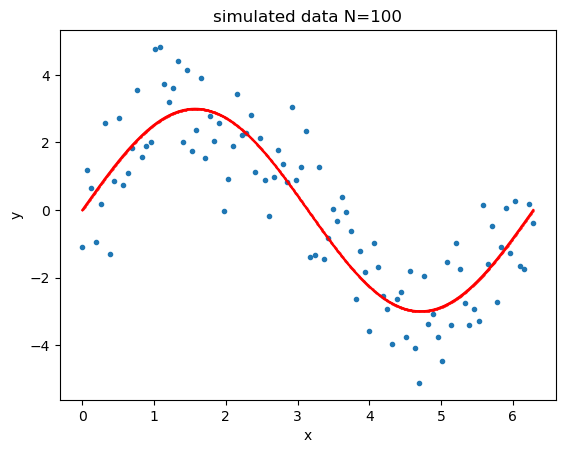

In [3]:
def create_sine_data(n = 300):
    np.random.seed(123)
    x = np.linspace(0,1*2*np.pi,n)
    y = 3 * np.sin(x) + np.random.normal(0,1,n)
    return x,y

def plot_base(x, y, x_0, y_0):
    plt.scatter(x=x,y=y,marker='.',alpha=1)
    plt.plot(x_0,y_0, 'r.-', markersize = 1)
    plt.title("simulated data N=" + str(len(x)))
    plt.xlabel("x")
    plt.ylabel("y")
    
## use custom function to simulate some data 
x_0 = np.linspace(0,1*2*np.pi,1000) # x_0 is the linspace for ploting predicted points  
y_0 = 3*np.sin(x_0)

N = 100  # medium sample size 
x, y = create_sine_data(N) 
plot_base(x, y, x_0, y_0)

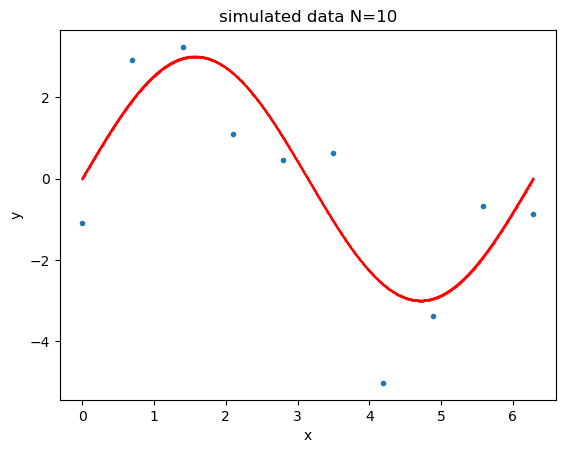

In [4]:
Ns = 10  # small sample size  
xs, ys = create_sine_data(Ns) 
plot_base(xs, ys, x_0, y_0)

We generated data sets of **medium (N=100)** and **small (N=10)** sample sizes for our single-input curve fitting exercise. The underlying true data generating process is shown as a red curve.  This serves as a case study for the general issue of **over-fitting** that can happen in machine learning.  We begin our discussion with observing over-fitting in a linear model and applying **regularization techniques** (Lasso and Ridge) to mitigate it.      

# 1. Linear Regression and Regularization Examples

## 1.1 Linear Regression Fit

In [5]:
import sklearn
from sklearn.linear_model import LinearRegression

def lin_reg_order_m(x, y, m=1):
    x_mat = lambda x: np.power(x, np.array(np.arange(1,m+1)).reshape(m,1)).T
    lin_reg = LinearRegression()
    lin_reg.fit(x_mat(x), y)
    y_hat = lambda x: lin_reg.predict(x_mat(x))
    return lin_reg, x_mat, y_hat

def plot_fit(x_1, y_1, model_lab, markersize=1, linewidth=2):  # given above def of x, y, x_0, y_0
    plot_base(x, y, x_0, y_0) 
    plt.plot(x_1, y_1, 'g.-', markersize = markersize, linewidth=linewidth)
    plt.title("simulated data N=" + str(len(x)) + ', ' + model_lab)

def plot_fit_s(x_1, y_1, model_lab, markersize=1, linewidth=2):  # given above def of xs, ys, x_0, y_0
    plot_base(xs, ys, x_0, y_0)
    plt.plot(x_1, y_1, 'g.-', markersize = markersize, linewidth=linewidth)
    plt.title("simulated data N=" + str(len(xs)) + ', ' + model_lab)

A priori we generally do not know the right choice for the degree of polynomial fit in a given problem. We may try several versions of polynomials, visually inspect the fit, and/or calculate some statistics on the goodness of fit. 

In our example,
- degree 1: case of under-fitting
- degree 3: case of correctly chosen degree
- degree 9: case of over-fitting

We can completely visualize this single-input example for how a curve fits the data, and it is helpful to have a basic intuition about under-fitting and over-fitting. 

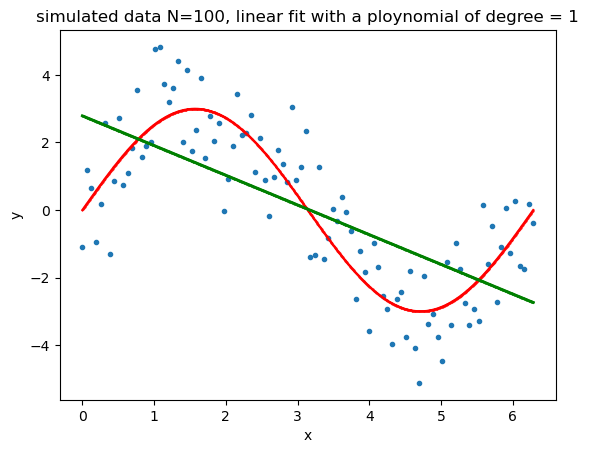

In [6]:
lm_1, x_1, yh_1 = lin_reg_order_m(x,y,1)
plot_fit(x_0, yh_1(x_0), 'linear fit with a ploynomial of degree = 1')

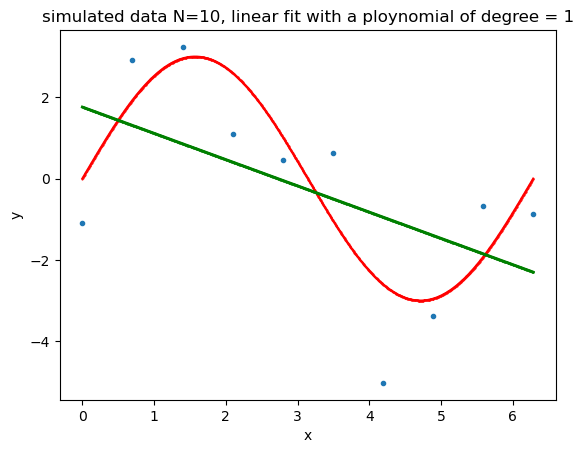

In [7]:
lm_1s, x_1s, yh_1s = lin_reg_order_m(xs,ys,1)
plot_fit_s(x_0, yh_1s(x_0), 'linear fit with a ploynomial of degree = 1')

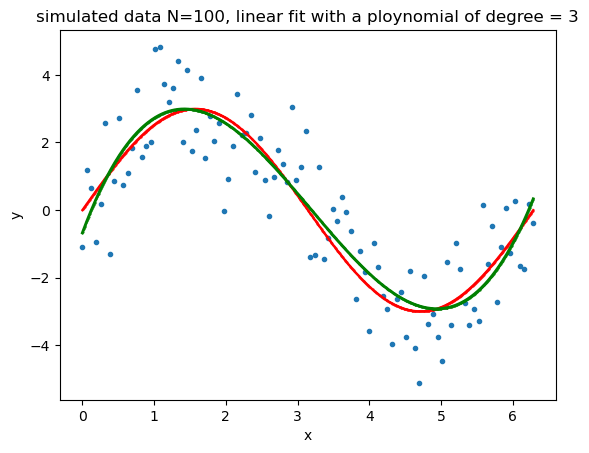

In [8]:
lm_3, x_3, yh_3 = lin_reg_order_m(x,y,3)
plot_fit(x_0, yh_3(x_0), 'linear fit with a ploynomial of degree = 3')

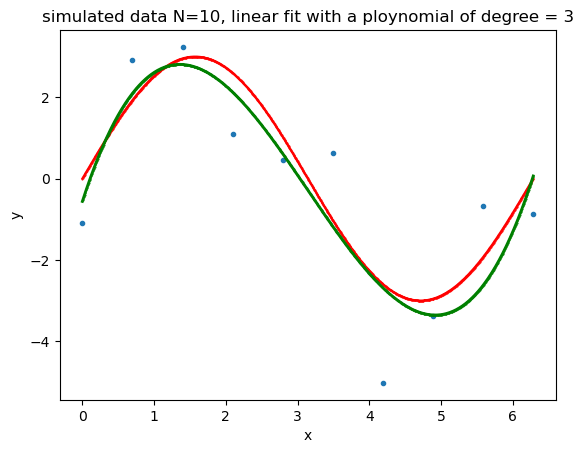

In [9]:
lm_3s, x_3s, yh_3s = lin_reg_order_m(xs,ys,3)
plot_fit_s(x_0, yh_3s(x_0), 'linear fit with a ploynomial of degree = 3')

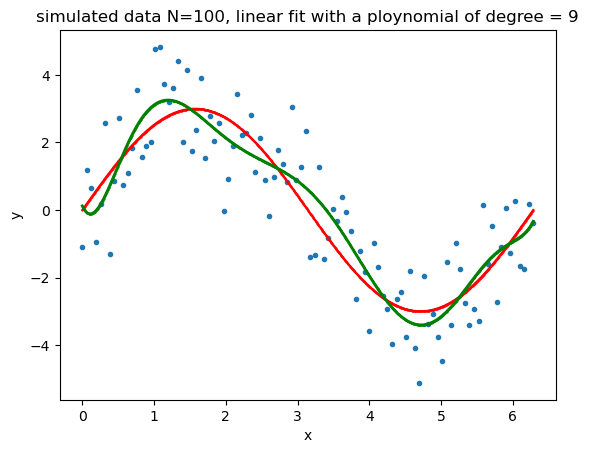

In [10]:
lm_9, x_9, yh_9 = lin_reg_order_m(x,y,9)
plot_fit(x_0, yh_9(x_0), 'linear fit with a ploynomial of degree = 9')

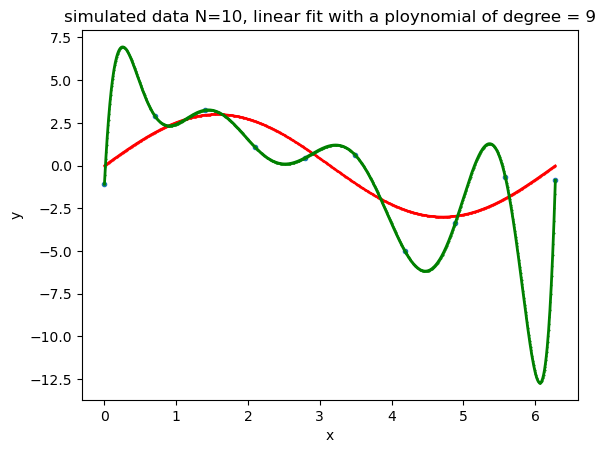

In [11]:
lm_9s, x_9s, yh_9s = lin_reg_order_m(xs,ys,9)
plot_fit_s(x_0, yh_9s(x_0), 'linear fit with a ploynomial of degree = 9')

## 1.2 Regularized model: Ridge, Lasso

Ridge and Lasso impose an additional cost in the minimization problem based on how far parameters deviate from zero. 
- parameter being zero is equivalent to dropping the associated variable from the model
- parameter being near-zero means to nearly ignoring the effect of the associated variable
- parameter significantly away from zero can be discounted toward zero compared to an un-regularized model

Ridge and Lasso differ in their distance measure (the deviation from zero) in that Ridge uses the squared distance and Lasso uses the absolute distance. 


In [12]:
from sklearn.linear_model import Ridge

def ridge_reg_order_m(x, y, m=1, alpha=1):
    x_mat = lambda x: np.power(x, np.array(np.arange(1,m+1)).reshape(m,1)).T
    ridge_reg = Ridge(alpha=alpha, solver="cholesky", random_state=42)
    ridge_reg.fit(x_mat(x), y)
    y_hat = lambda x: ridge_reg.predict(x_mat(x))
    return ridge_reg, x_mat, y_hat

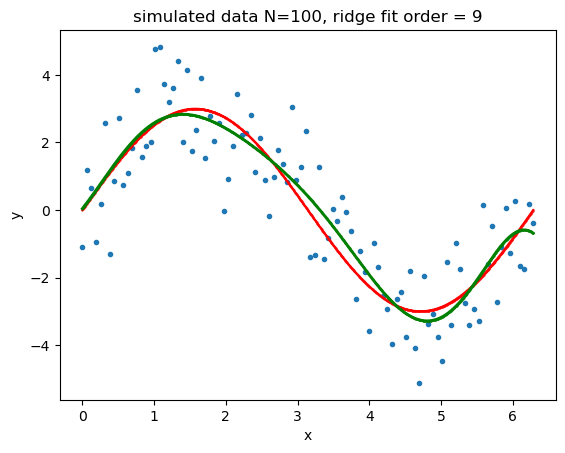

In [13]:
ridge_9, x_9, y_ridge_9 = ridge_reg_order_m(x, y, 9, alpha=0.5)
plot_fit(x_0, y_ridge_9(x_0), 'ridge fit order = 9')

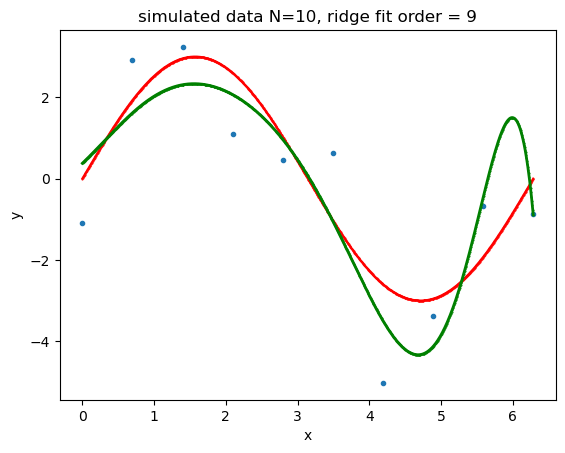

In [14]:
ridge_9s, x_9s, y_ridge_9s = ridge_reg_order_m(xs, ys, 9, alpha=0.5)
plot_fit_s(x_0, y_ridge_9s(x_0), 'ridge fit order = 9')

In [15]:
from sklearn.linear_model import Lasso

def lasso_reg_order_m(x, y, m=1, alpha=0.1):
    x_mat = lambda x: np.power(x, np.array(np.arange(1,m+1)).reshape(m,1)).T
    lasso_reg = Lasso(alpha=alpha)
    lasso_reg.fit(x_mat(x), y)
    y_hat = lambda x: lasso_reg.predict(x_mat(x))
    return lasso_reg, x_mat, y_hat

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.702e+01, tolerance: 5.575e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


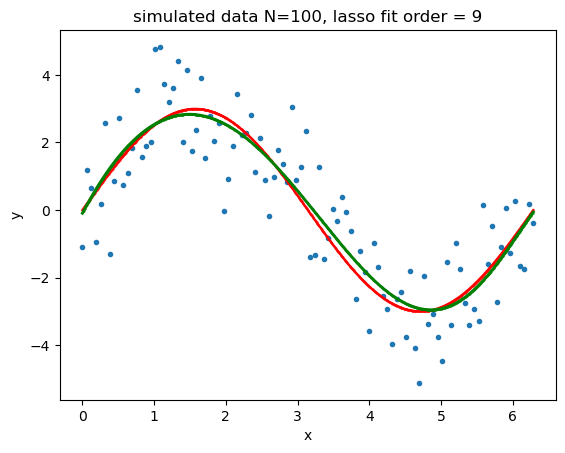

In [16]:
lasso_9, x_9, y_lasso_9 = lasso_reg_order_m(x, y, 9, alpha=0.01)
plot_fit(x_0, y_lasso_9(x_0), 'lasso fit order = 9')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.529e+00, tolerance: 5.916e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


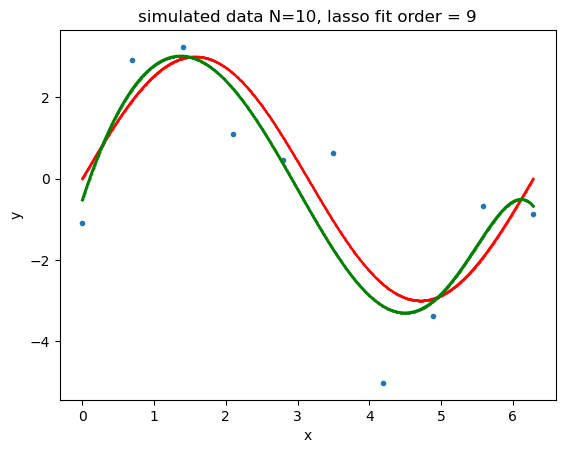

In [17]:
lasso_9s, x_9s, y_lasso_9s = lasso_reg_order_m(xs, ys, 9, alpha=.02)
plot_fit_s(x_0, y_lasso_9s(x_0), 'lasso fit order = 9')

In [18]:
import pandas as pd
coeff_9 = pd.DataFrame([np.append(lm_9s.intercept_,lm_9s.coef_),
                        np.append(ridge_9s.intercept_, ridge_9s.coef_),
                        np.append(lasso_9s.intercept_, lasso_9s.coef_)]).transpose()
coeff_9.index = ['intercept'] + ['x^' + str(i) for i in np.arange(1,10)]
coeff_9.columns = ['linear','ridge','lasso']
coeff_9

,linear,ridge,lasso
intercept,-1.085631,0.375924,-5.260557e-01
x^1,81.588059,1.693125,5.379188e+00
x^2,-286.469524,0.496471,-2.142742e+00
x^3,430.910887,-0.392966,4.324366e-02
x^4,-344.588872,-0.403953,1.955720e-02
x^5,159.636485,0.352332,2.340223e-03
x^6,-44.146908,-0.108118,1.847739e-04
x^7,7.172241,0.013811,3.481515e-07
x^8,-0.630477,-0.000372,-3.748756e-06
x^9,0.023110,-0.000035,-1.040468e-06


- **Ridge**: parameters are **shrunk toward zero** (preventing coefficients that extremely deviate from zero) 
- **Lasso**: typically some parameters are **shrunk exactly to zero** (large penalty hyperparameter alpha leading to more coefficients to zero) -- that may not happen in the current example

## 1. Neural Network (Standard/Nonlinear Fit)
We first fit a **non-linear** neural network as it is the standard usage. That is, **the neural network will figure  out how to fit a layered weight structure and map from a single input $[x]$ to the target output** .   

In [19]:
from tensorflow import keras
from keras import optimizers

In [20]:
## try changing model layers, optimizer, and optmier learning rate 
## to practice fitting this model 

model_nonlin = keras.models.Sequential([  # it can be any arbitrary structure
    keras.layers.Dense(1, input_dim=1),
    keras.layers.Dense(3, activation='tanh'), # helps to allow for negative values here
    keras.layers.Dense(2, activation='tanh'),
    keras.layers.Dense(1, activation='linear') # the final activation should be linear
])
model_nonlin.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [21]:
## use a decaying learning rate if you like
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.002,
    decay_steps=8000,
    decay_rate=0.96)

model_nonlin.compile(loss='mean_squared_error', 
                  optimizer=keras.optimizers.SGD(learning_rate=lr_schedule)) 
                 #optimizer=keras.optimizers.Adam(learning_rate=0.0002))

In [22]:
# shuffle inputs
np.random.seed(1234)
ind_p = np.random.permutation(len(x))
yp, x_1p = y[ind_p], x[ind_p]

In [23]:
loss, val_loss = [], []

## use early stopping rule if you like
# cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, 
#                                                      restore_best_weights=True)

history = model_nonlin.fit(x=x_1p, y=yp, batch_size=1,
                epochs=100, #callbacks=[cb_early_stopping], 
                verbose = 2, validation_split = 0.4)
loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])

Epoch 1/100
60/60 - 1s - loss: 6.4560 - val_loss: 6.0848
Epoch 2/100
60/60 - 0s - loss: 5.2349 - val_loss: 5.8905
Epoch 3/100
60/60 - 0s - loss: 4.6829 - val_loss: 5.4904
Epoch 4/100
60/60 - 0s - loss: 4.1724 - val_loss: 4.4773
Epoch 5/100
60/60 - 0s - loss: 3.5187 - val_loss: 3.6127
Epoch 6/100
60/60 - 0s - loss: 3.0167 - val_loss: 3.1276
Epoch 7/100
60/60 - 0s - loss: 2.5393 - val_loss: 2.9553
Epoch 8/100
60/60 - 0s - loss: 2.3769 - val_loss: 2.6087
Epoch 9/100
60/60 - 0s - loss: 2.1950 - val_loss: 2.8891
Epoch 10/100
60/60 - 0s - loss: 2.2729 - val_loss: 3.5550
Epoch 11/100
60/60 - 0s - loss: 2.1243 - val_loss: 2.4292
Epoch 12/100
60/60 - 0s - loss: 2.1310 - val_loss: 2.3447
Epoch 13/100
60/60 - 0s - loss: 2.0821 - val_loss: 2.9388
Epoch 14/100
60/60 - 0s - loss: 2.0042 - val_loss: 2.4326
Epoch 15/100
60/60 - 0s - loss: 2.0616 - val_loss: 2.8065
Epoch 16/100
60/60 - 0s - loss: 2.0109 - val_loss: 2.6248
Epoch 17/100
60/60 - 0s - loss: 1.9686 - val_loss: 2.2609
Epoch 18/100
60/60 - 0s

In [24]:
def plot_loss(loss, val_loss=None, ylim=None):
    plt.plot(loss, label='loss')
    if (val_loss is not None): plt.plot(val_loss, label='val_loss')
    if (ylim is not None): plt.ylim([0, ylim])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

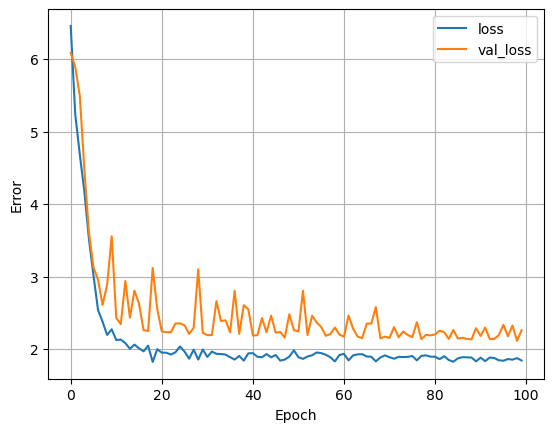

In [25]:
plot_loss(loss, val_loss)

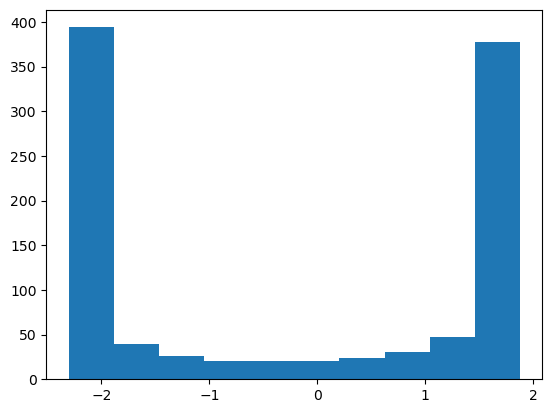

In [26]:
y_nn = model_nonlin.predict(x_0)
plt.hist(y_nn);

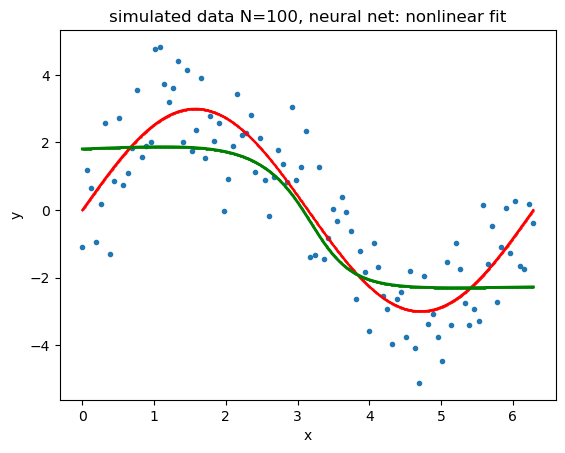

In [27]:
plot_fit(x_0, y_nn, 'neural net: nonlinear fit')

### With small sample

In [28]:
## try changing model layers, optimizer, and optmier learning rate 
## to practice fitting this model 

model_nonlin_s = keras.models.Sequential([  # it can be any arbitrary structure
    keras.layers.Dense(1, input_dim=1),
    keras.layers.Dense(3, activation='tanh'), # need to allow for negative values
    keras.layers.Dense(2, activation='tanh'),
    keras.layers.Dense(1, activation='linear') # the final activation should be linear
])
#model_nonlin_s.summary()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.004,
    decay_steps=1000,
    decay_rate=0.96)

model_nonlin_s.compile(loss='mean_squared_error', 
                  optimizer=keras.optimizers.SGD(learning_rate=lr_schedule))

In [29]:
# shuffle inputs
np.random.seed(1234)
ind_ps = np.random.permutation(len(xs))
ysp, xs_1p = ys[ind_ps], xs[ind_ps]

In [30]:
cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8, 
                                                     restore_best_weights=True)

history = model_nonlin_s.fit(x=xs_1p, y=ysp, batch_size=1,
                epochs=100, callbacks=[cb_early_stopping], verbose = 1) 
                # can't afford to split data for validation for the small sample case 
    
loss = history.history['loss']

Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 6.0272
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 5.9025
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 5.8358
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 5.8216
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 5.6713
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 5.6634
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 5.6487
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 5.6432
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 5.5379
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 5.4417
Epoch 11/100
10/10 [==============================] - 0s 1ms/step - loss: 5.3862
Epoch 12/100
10/10 [==============================] - 0s 1ms/step - loss: 5.4065
Epoch 13/100
10/10 [=================

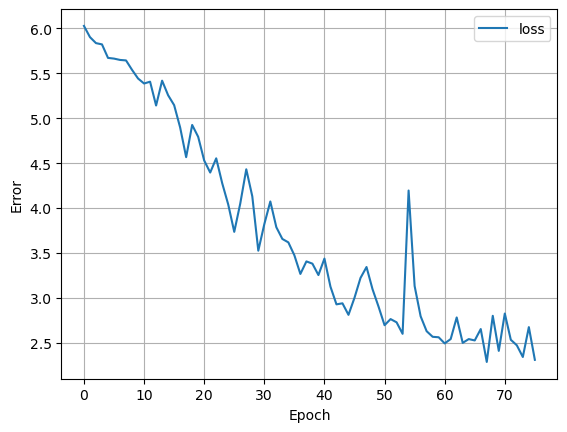

In [31]:
plot_loss(loss) 

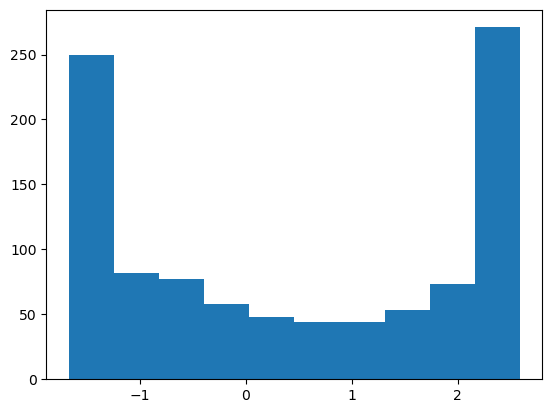

In [32]:
y_nn_s = model_nonlin_s.predict(x_0)
plt.hist(y_nn_s);

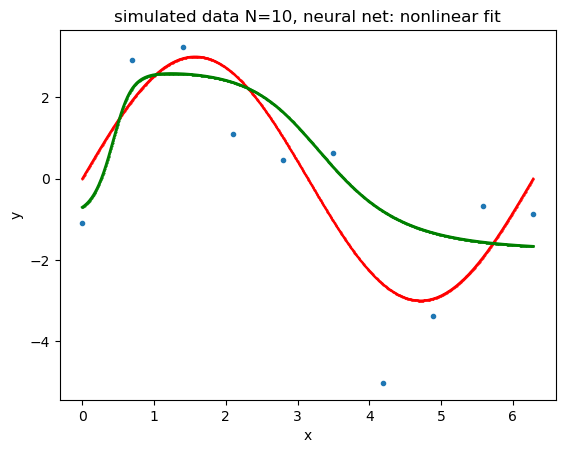

In [33]:
plot_fit_s(x_0, y_nn_s, 'neural net: nonlinear fit')

Not bad!?  So, one could estimate a Neural Network model with 10 data points...I wasn't sure.

*Try chancing structure and optimizer etc to see how easy it is to train and obtain reasonable results.*


## 2. Linear Model using Neural Network 

This time we manually feed expanded inputs $[x, x^2, x^3]$ and fit a linear model with neural networks. (Just to show that we could do that.)

We estimate a 3rd degree polynomial given by 
$$y=b + a_1*x + a_2 * x^2 + a_3 * x^3 + \varepsilon$$
by following the example above. 

In [34]:
## try changing optimizer, optmier learning rate, and starting values (a, b below) 
## to practice fitting this model 

model_lin = keras.models.Sequential([
    keras.layers.Dense(1, input_dim=3, activation='linear') # the last activation must be 'linear'/None 
])

model_lin.summary()

initial_learning_rate = 0.2

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96)

model_lin.compile(loss='mean_squared_error', 
                   optimizer=keras.optimizers.SGD(learning_rate=lr_schedule)) 
                 #optimizer=keras.optimizers.Adam(learning_rate=0.0003))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [35]:
# expand inputs: x, x^2, x^3 
x_mat_3 = np.ma.transpose(np.power(x, np.mat(np.arange(1,3+1)).reshape(3,1)))
x_0_mat_3 = np.ma.transpose(np.power(x_0, np.mat(np.arange(1,3+1)).reshape(3,1)))

# standardize inputs
for i in range(0,3):
    x_mat_3[:,i] = (x_mat_3[:,i] - np.mean(x_mat_3[:,i]))/np.std(x_mat_3[:,i])
    x_0_mat_3[:,i] = (x_0_mat_3[:,i] - np.mean(x_0_mat_3[:,i]))/np.std(x_0_mat_3[:,i])

# shuffle inputs
x_mat_3p = x_mat_3[ind_p,:]

In [36]:
# repeat it for small sample version
# expand inputs: x, x^2, x^3 
xs_mat_3 = np.ma.transpose(np.power(xs, np.mat(np.arange(1,3+1)).reshape(3,1)))

# standardize inputs
for i in range(0,3):
    xs_mat_3[:,i] = (xs_mat_3[:,i] - np.mean(xs_mat_3[:,i]))/np.std(xs_mat_3[:,i])

# shuffle inputs
xs_mat_3p = xs_mat_3[ind_ps,:]

In [37]:
# linear reg to preview OLS results -- this may help select the starting value
lin_reg3 = LinearRegression()
lin_reg3.fit(x_mat_3p, yp)
lin_reg3.coef_, lin_reg3.intercept_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


(array([ 10.47561177, -30.83775244,  19.39010097]), 0.02710907349035661)

In [38]:
# a for slopes and b for the intercept 

a = np.array([0,0,0],dtype="float32",ndmin=2).reshape(3,1)
# a = np.array([10,-30,20],dtype="float32",ndmin=2).reshape(3,1)
# a = np.array([10,-10,10],dtype="float32", ndmin=2).reshape(3,1)

b = np.array([0],dtype="float32", ndmin=1)
model_lin.set_weights([a,b])

a,b = model_lin.get_weights()
print("slope_x=",a[0][0],", slope_x^2=",a[1][0],", slope_x^3=",a[2][0],", intercept=",b[0])

slope_x= 0.0 , slope_x^2= 0.0 , slope_x^3= 0.0 , intercept= 0.0


In [39]:
# forwad pass calculation of the loss (mse) for given values of slope a, intercept b
model_lin.evaluate(x_mat_3, y, verbose=2)

4/4 - 0s - loss: 5.5755


5.575497627258301

In [40]:
loss, val_loss = [], []
cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, #min_delta =0.01,
                                                     restore_best_weights=True)

## This is a standard fitting approach:
# history = model_lin.fit(x=x_mat_3p, y=yp, batch_size=1,
#                 epochs=500, callbacks=[cb_early_stopping], verbose = 0, validation_split = 0.2)
# loss.extend(history.history['loss'])
# val_loss.extend(history.history['val_loss'])

## The following runs the model over several iterations and shows intermmediate results for the slopes and intecept. 
for i in range(0, int(30000/100)):
    history = model_lin.fit(x=x_mat_3p, y=yp, batch_size=32,
                    epochs=100, callbacks=[cb_early_stopping], verbose = 0, validation_split = 0.2)
    loss.extend(history.history['loss'])
    val_loss.extend(history.history['val_loss'])

    if i % 10 == 0:
        a,b = model_lin.get_weights()
        mse=np.round(np.mean(np.square(y - model_lin.predict(x_mat_3).reshape(len(x_mat_3),))),3)
        print("Epoch:",(i+1)*100, "slope_x=",a[0][0],", slope_x^2=",a[1][0],", slope_x^3=",a[2][0],", intercept=",b[0], 'MSE=',mse)
        

print("Epoch:",(i+1)*100, "slope_x=",a[0][0],", slope_x^2=",a[1][0],", slope_x^3=",a[2][0],", intercept=",b[0], 'MSE=',mse)

Epoch: 100 slope_x= -0.8056336 , slope_x^2= -0.7390109 , slope_x^3= -0.44582278 , intercept= -0.28814307 MSE= 3.32
Epoch: 1100 slope_x= -0.35366103 , slope_x^2= -2.912577 , slope_x^3= 2.2285197 , intercept= -0.07219381 MSE= 2.892
Epoch: 2100 slope_x= 0.5201924 , slope_x^2= -5.2483997 , slope_x^3= 3.654814 , intercept= 0.014376633 MSE= 2.586
Epoch: 3100 slope_x= 1.4966466 , slope_x^2= -7.1622715 , slope_x^3= 4.981488 , intercept= 0.07472962 MSE= 2.812
Epoch: 4100 slope_x= 1.5578818 , slope_x^2= -9.0409975 , slope_x^3= 5.422312 , intercept= -0.030190852 MSE= 2.52
Epoch: 5100 slope_x= 2.7614186 , slope_x^2= -11.098499 , slope_x^3= 7.0853376 , intercept= -0.049138065 MSE= 1.969
Epoch: 6100 slope_x= 3.145914 , slope_x^2= -12.709728 , slope_x^3= 7.8874426 , intercept= -0.033752687 MSE= 1.956
Epoch: 7100 slope_x= 3.6116774 , slope_x^2= -13.36488 , slope_x^3= 8.386093 , intercept= -0.022170043 MSE= 1.804
Epoch: 8100 slope_x= 4.0021315 , slope_x^2= -14.696617 , slope_x^3= 9.211949 , intercept= 

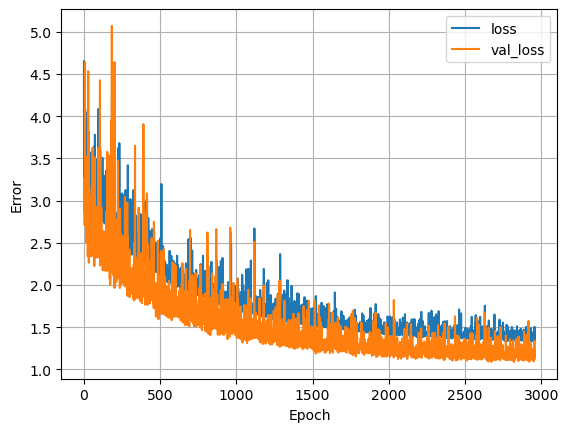

In [41]:
plot_loss(loss, val_loss)

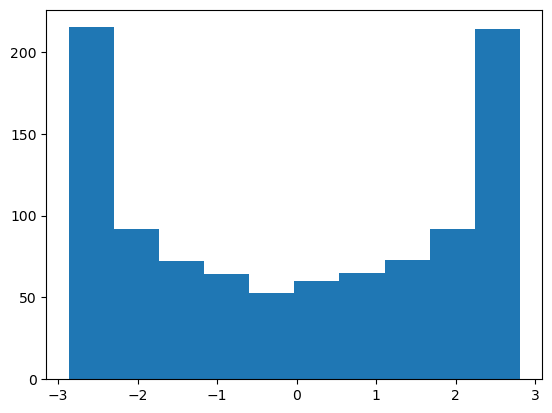

In [42]:
y_nn_3 = model_lin.predict(x_0_mat_3)
plt.hist(y_nn_3);

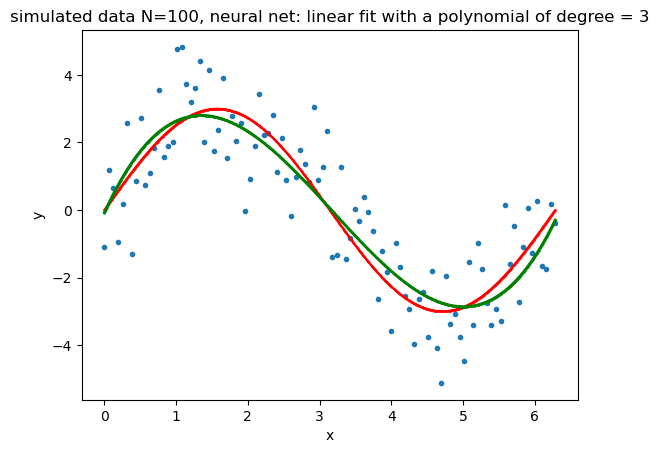

In [43]:
plot_fit(x_0, y_nn_3, 'neural net: linear fit with a polynomial of degree = 3')

## 3. Linear Model using tf.GradientTape updates

One could also estimate model parameters by iteratively applying **gradient updates**. 

Why `tf.GradientTape` (https://www.tensorflow.org/guide/autodiff )?  

> `tf.GradientTape` is one of the most potent tools a machine learning engineer can have in their arsenal — its style of programming combines the beauty of mathematics with the power and simplicity of TensorFlow and Keras. 
https://medium.com/analytics-vidhya/tf-gradienttape-explained-for-keras-users-cc3f06276f22

> The most useful application of `Gradient Tape` is when you design a custom layer in your keras model for example--or equivalently designing a custom training loop for your model. [...] `GradientTape` is a mathematical tool for automatic differentiation (autodiff), which is the core functionality of TensorFlow. It is a key part of performing the autodiff. https://stackoverflow.com/questions/53953099/what-is-the-purpose-of-the-tensorflow-gradient-tape 


Thus, it may be useful to know `tf.GradientTape` method that gives more **flexibility in specifying how the model weights are updated**. 


- Tensorflow Eager's introductory page is also helpful: https://www.tensorflow.org/guide/eager 
- Notebook `nb_ch03_06` contains more examples. 


In [44]:
## suppose these are slope=a and intercept=b and we iteratively update them 
a = tf.Variable([[0.0],[-0.0],[0.0]],name='a', trainable=True)
b = tf.Variable(0.0,name='b', trainable=True)
a, b

(<tf.Variable 'a:0' shape=(3, 1) dtype=float32, numpy=
 array([[ 0.],
        [-0.],
        [ 0.]], dtype=float32)>,
 <tf.Variable 'b:0' shape=() dtype=float32, numpy=0.0>)

In [45]:
# practice for one round: gradient(y,x) calculates the autodiff of y with respect to x  
with tf.GradientTape(persistent=True) as tape:
    y_hat = tf.Variable(x_mat_3p,dtype=tf.float32) @ a + b
    loss = tf.reduce_mean(tf.square(yp-y_hat))
    [grad_a, grad_b] = tape.gradient(loss, [a, b])
    
print(grad_a.numpy().squeeze(), grad_b.numpy())

[ 9.8225428e-11 -8.1490725e-10 -4.0745363e-10] -0.054218132


Let's start with an example with a simple shape.  

In [46]:
# A simple example of GradientTape

import random

# Mock training data
x_train = np.asarray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y_train = np.asarray([10*x - 3* (x**2) + 6* (x**3) + 5 for x in x_train]) # y = 10x - 3x^2 + 6*x^3 +5

x_train_mat = np.array([x_train, x_train**2, x_train**3]).T.astype('float32')

# Standardize inputs
for i in range(0,3):
    x_train_mat[:,i] = (x_train_mat[:,i] - np.mean(x_train_mat[:,i]))/np.std(x_train_mat[:,i])

# Convert data to tf variable 
x_train_tf = tf.Variable(x_train_mat, dtype=tf.float32, trainable=False)
y_train_tf = tf.Variable(y_train.reshape([len(y_train),1]), dtype=tf.float32, trainable=False) 

# Trainable variables
a = tf.Variable([[random.random()], [random.random()], [random.random()]], trainable=True)
b = tf.Variable(random.random(), trainable=True, dtype=tf.float32)

# Step function
def step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([a,b])

        # Make prediction
        pred_y = real_x @ a  + b
        
        # Calculate loss
        reg_loss =(real_y - pred_y)**2 
        
    # Calculate gradients -- tape.gradient() can use either the vector or vector sum
    [a_gradients, b_gradients] = tape.gradient(reg_loss, (a, b))

    # Update variables: subtract value and assign to itself
    a.assign_sub(a_gradients * 0.01)
    b.assign_sub(b_gradients * 0.01)


# Training loop
for _ in range(20000):
    step(x_train_tf, y_train_tf)

print(f'y ≈ {a.numpy()[0]}z1 + {a.numpy()[1]}z2 + {a.numpy()[2]}z3 + {b.numpy()}' +
      '\n where z1, z2, z3 are the standardized x, x^2, x^3 respectively.')

y ≈ [31.044582]z1 + [-96.993835]z2 + [1936.1208]z3 + 1599.9998779296875
 where z1, z2, z3 are the standardized x, x^2, x^3 respectively.


Text(0, 0.5, 'y')

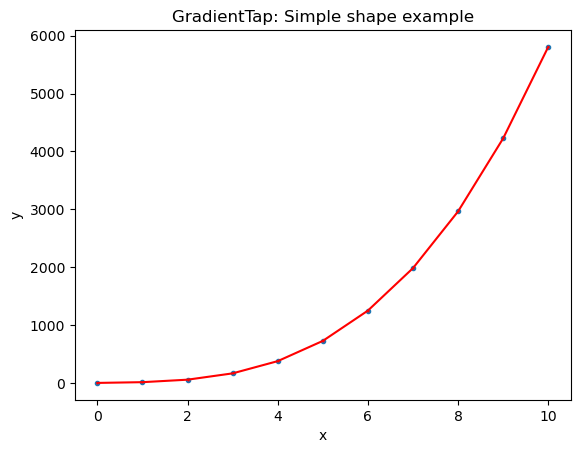

In [47]:
y_train_hat = x_train_tf @ a  + b
plt.scatter(x=x_train, y=y_train, marker='.', alpha=1)
plt.plot(x_train, y_train_hat, 'r.-', markersize = 1)
plt.title("GradientTap: Simple shape example")
plt.xlabel("x")
plt.ylabel("y")

That worked well. Now let's try for our simulated data. 

In [48]:
from time import time

# Trainable variables
a = tf.Variable([[0.5],[-0.5],[0.5]], trainable=True,  dtype=tf.float32)
b = tf.Variable(0.5,  trainable=True,  dtype=tf.float32)

# Convert data to tf variable 
x_mat_3p_tf = tf.Variable(x_mat_3p, dtype=tf.float32, trainable=False) 
yp_tf = tf.Variable(yp.reshape([len(yp),1]), dtype=tf.float32, trainable=False) 

# learning rate adjustment utilities
def expo_decay_func(ini_rate, decay_rate, decay_steps):
    return lambda i: ini_rate * decay_rate ** (i / decay_steps)

expo_decay = expo_decay_func(ini_rate = 0.0007, decay_rate=0.96, decay_steps=2000)

def step_learning_rate(epoch):
    if epoch > 10000:
        r = 0.5e-5
    elif epoch > 1000:
        r = 1e-4
    elif epoch > 100:
        r = 1e-3
    else:
        r = 1e-2  
    return r

        
start = time()
for i in range(20000): 
    with tf.GradientTape() as tape: 
        tape.watch([a,b])
        
        # predict 
        y_hat = x_mat_3p_tf @ a + b
        
        # calculate loss
        loss = tf.square(yp_tf - y_hat)

    # Calculate gradients
    grad_a, grad_b = tape.gradient(loss, [a, b])
    
    # Adjust learning rate if needed 
#   eta = step_learning_rate(i)
    eta = expo_decay(i)
#   eta = 0.0005 
    
    # Update variables
    a.assign_sub(eta * grad_a)
    b.assign_sub(eta * grad_b)
    
    # Print intermmediate results
    if (i % 5000 == 0): 
        t = time() - start
        print("Epoch:",i, "slope=", a.numpy().squeeze(), ", intercept=", b.numpy(), 
              #",\n gradient_a", tf.reduce_mean(grad_a).numpy().squeeze(),  ", gradient_b", tf.reduce_mean(grad_b).numpy(),
              ",\n mse=", tf.reduce_mean(loss).numpy(), "time for 1000 epochs ", round(t/5,2))
        start = time()

Epoch: 0 slope= [ 0.20790952 -0.78842974  0.23559907] , intercept= 0.43379527 ,
 mse= 7.482154 time for 1000 epochs  0.0
Epoch: 5000 slope= [  4.986693 -17.12902   10.88925 ] , intercept= 0.02710903 ,
 mse= 1.5833037 time for 1000 epochs  1.03
Epoch: 10000 slope= [  7.752929 -24.037771  15.173398] , intercept= 0.027109 ,
 mse= 1.327827 time for 1000 epochs  1.08
Epoch: 15000 slope= [  9.02988  -27.22698   17.151035] , intercept= 0.027108988 ,
 mse= 1.267963 time for 1000 epochs  0.99


In [49]:
print('slope=', a.numpy().squeeze(), ', intercept=', b.numpy(), ', loss=', tf.reduce_mean(loss).numpy())

slope= [  9.659165 -28.79863   18.125626] , intercept= 0.027109021 , loss= 1.2519536


 We can make this more efficient and faster by compiling by adding a `tf.function` decorator.  
 https://www.tensorflow.org/api_docs/python/tf/function

In [50]:
# Trainable variables
a = tf.Variable([[0.5],[-0.5],[0.5]], trainable=True,  dtype=tf.float32)
b = tf.Variable(0.5,  trainable=True,  dtype=tf.float32)

eta = 0.0005 

@tf.function # Will tell tf to build a graph from this code
def train_step():
    # predict 
    y_hat = x_mat_3p_tf @ a + b
        
    # calculate loss
    loss = tf.square(yp_tf - y_hat)

    # Calculate gradients
    grad_a, grad_b = tape.gradient(loss, [a, b])
    
    # Update variables
    a.assign_sub(eta * grad_a)
    b.assign_sub(eta * grad_b)
    
for i in range(20000):
    with tf.GradientTape() as tape: #Record the gradients from now on
        train_step()
    
        # Print intermmediate results
        if (i % 5000 == 0): 

            t = time() - start
            print("Epoch:",i, "slope=", a.numpy().squeeze(), ", intercept=", b.numpy(), 
                  #",\n gradient_a", tf.reduce_mean(grad_a).numpy().squeeze(),  ", gradient_b", tf.reduce_mean(grad_b).numpy(),
                  ",\n mse=", tf.reduce_mean(loss).numpy(), "time for 1000 epochs ", round(t/5,2))
            start = time()

Epoch: 0 slope= [ 0.29136392 -0.7060213   0.3111422 ] , intercept= 0.4527109 ,
 mse= 1.2519536 time for 1000 epochs  1.03
Epoch: 5000 slope= [  3.817334 -14.208509   9.078224] , intercept= 0.027109032 ,
 mse= 1.2519536 time for 1000 epochs  0.28
Epoch: 10000 slope= [  6.760252 -21.558537  13.636012] , intercept= 0.027108995 ,
 mse= 1.2519536 time for 1000 epochs  0.26
Epoch: 15000 slope= [  8.4023075 -25.659609   16.179106 ] , intercept= 0.02710896 ,
 mse= 1.2519536 time for 1000 epochs  0.28


In [51]:
print('slope=', a.numpy().squeeze(), ', intercept=', b.numpy(), ', loss=', tf.reduce_mean(loss).numpy())

slope= [  9.318433 -27.947666  17.597946] , intercept= 0.027108999 , loss= 1.2519536


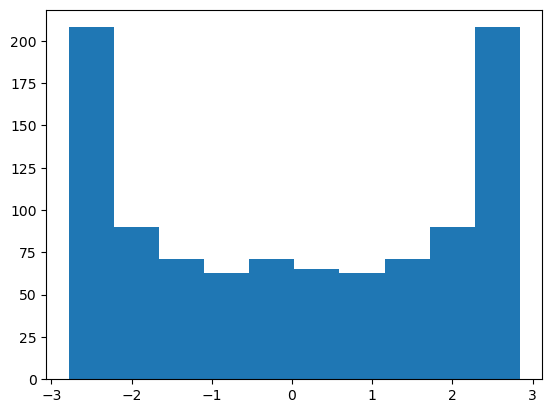

In [52]:
y_hat_0 = tf.Variable(x_0_mat_3,dtype=tf.float32) @ a + b
y_nn_v2 = y_hat_0.numpy().squeeze()
plt.hist(y_nn_v2);

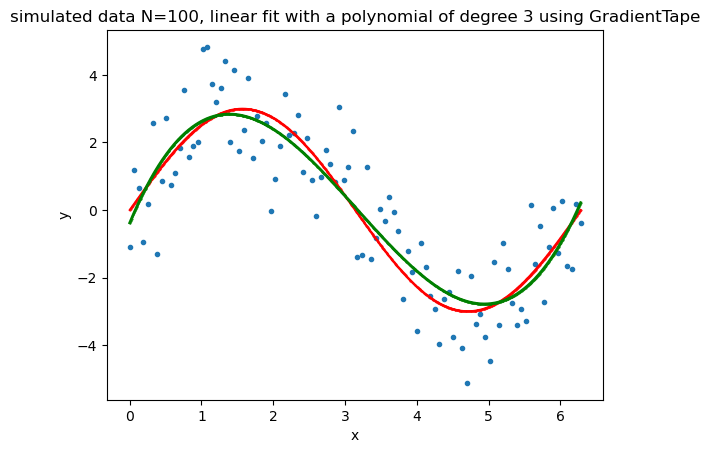

In [53]:
plot_fit(x_0, y_nn_v2, 'linear fit with a polynomial of degree 3 using GradientTape')

Note that GradientTape can be used with **Keras' models** as well as we show later. 

## 4. Linear Model fitting using Maximum Likelihood (constant variance)

This time, we will use a formula (normal density) to fit the data.

Let $f(y,\mu,\sigma)$ be the density of a normal distribution at $y$, given the parameters for mean $\mu$ and standard deviation $\sigma$:

$$
  f(y, \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(y - \mu)^2}{2 \sigma^2}}.
$$


Keras makes it easy to use ML modeling by simply converting **a target density function** (e.g., the formula above) into a **negative log likelihood** and passing this as **the loss function** in Keras's model.      

When taking the negative log of the above formula ($ - \ln f(y, \mu, \sigma) $) and minimizing it, $\mu$ is independent of $\sigma$. Thus, we don't need to estimate $\sigma$ and give some arbitrary, fixed value.

In [54]:
def f(y, mu, sigma=3):
    return (1/(sigma * tf.math.sqrt(2 * np.pi)) * tf.math.exp( - (y - mu)**2 / (2 * sigma**2)))
# note: the only thing that matters in the optimization is -(y - mu)**2.   Sigma is some constant.  

In [55]:
# Negative log likelihood
def NLL_loss(y,y_pred):
    loss = -tf.reduce_sum(tf.math.log(f(y,y_pred)))
    return loss

# Assume a linear model with a polynomial of degree 3
model_ml = keras.models.Sequential([
    keras.layers.Dense(1, batch_input_shape=(None,3), activation='linear')
])
model_ml.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Feed the NLL in the loss argument 

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.4,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

model_ml.compile(loss = NLL_loss, 
                 optimizer=keras.optimizers.SGD(learning_rate=lr_schedule))
              #   optimizer=keras.optimizers.Adam(learning_rate=0.0003))

In [57]:
# set a starting value if you like  
# a = np.array([10,-10,10],dtype="float32",ndmin=2).reshape(3,1)
a = np.array([0,0,0],dtype="float32",ndmin=2).reshape(3,1)
b = np.array([0],dtype="float32",ndmin=1)
model_ml.set_weights([a,b])

In [58]:
loss, val_loss= [], []
cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, 
                                                     restore_best_weights=True)

history = model_ml.fit(x=x_mat_3p, y=yp, batch_size=1,
                epochs=2000, callbacks=[cb_early_stopping], 
                       verbose = 0, validation_split = 0.2)
loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])

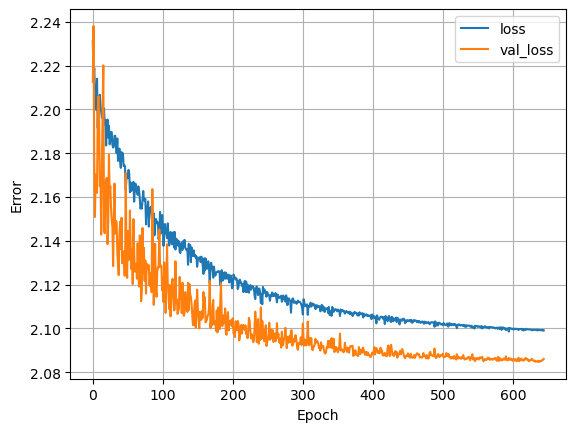

In [59]:
plot_loss(loss, val_loss)

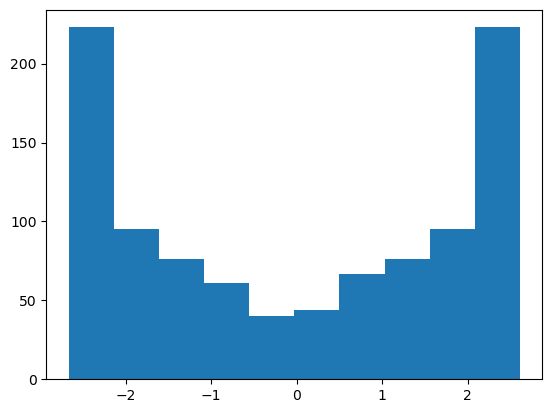

In [60]:
y_nn_3ml = model_ml.predict(x_0_mat_3)
plt.hist(y_nn_3ml);

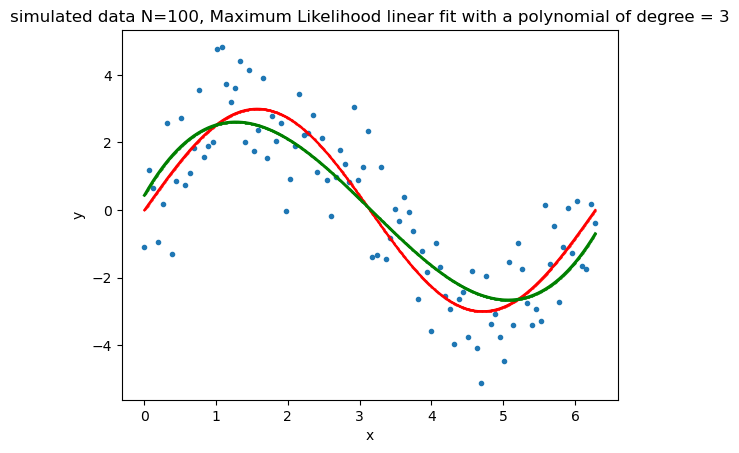

In [61]:
plot_fit(x_0, y_nn_3ml, 'Maximum Likelihood linear fit with a polynomial of degree = 3')

### With small sample

In [62]:
# Assume a linear model with a polynomial of degree 3
model_ml_s = keras.models.Sequential([
    keras.layers.Dense(1, batch_input_shape=(None,3), activation='linear')
])
model_ml_s.summary()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.9,
    decay_steps=1000,
    decay_rate=0.98)

model_ml_s.compile(loss = NLL_loss, 
                 optimizer=keras.optimizers.SGD(learning_rate=lr_schedule))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [63]:
loss, val_loss= [], []

history = model_ml_s.fit(x=xs_mat_3p, y=ysp, batch_size=1, epochs=1000, 
                       verbose = 0, validation_split = 0.2)
loss = history.history['loss']
val_loss = history.history['val_loss']

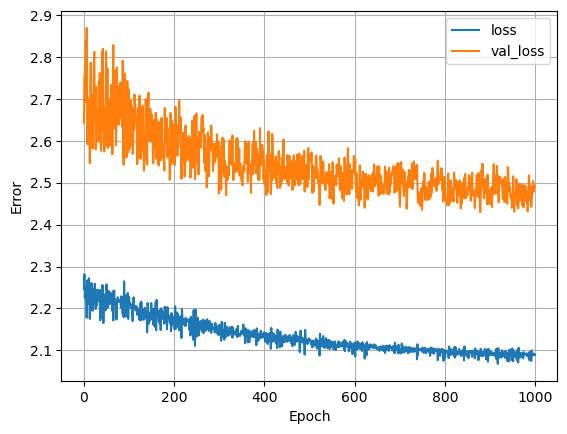

In [64]:
plot_loss(loss, val_loss)

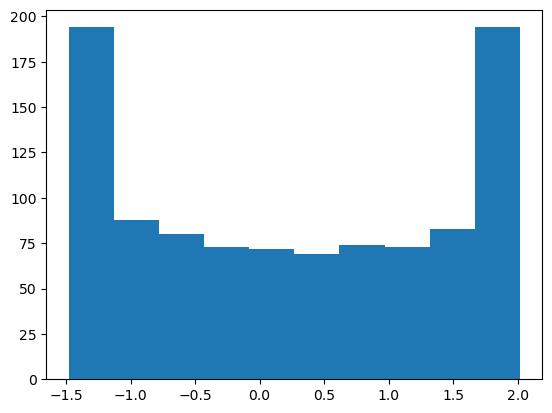

In [65]:
y_nn_3ml_s = model_ml_s.predict(x_0_mat_3)
plt.hist(y_nn_3ml_s);

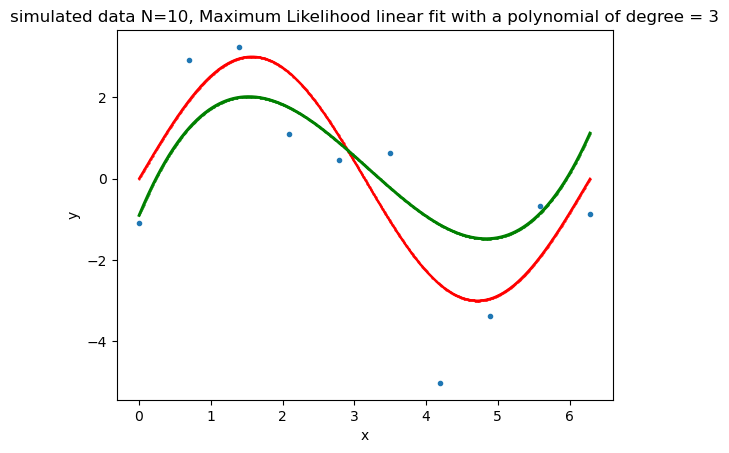

In [66]:
plot_fit_s(x_0, y_nn_3ml_s, 'Maximum Likelihood linear fit with a polynomial of degree = 3')

This appears that this simple model works for the small sample case. 

## 5. Linear Model fitting using Maximum Likelihood (Non-constant variance)

The previous model shows how to estimate a linear model via a maximum likelihood assuming a constant variance. 

When allowing for **the variance to vary**, we have a more general formula for the log likelihood (Equation 4.8 and notebook `nb_ch04_04`) :   

$$loss = NLL = \Sigma_i - log\left(\frac{1}{\sqrt{2 \pi \sigma_{xi}^2 }} \right) + \frac{(y_i -\mu_{xi})^2}{2\sigma_{xi}^2}$$ where subscript $xi$ indicates the conditioning input data point.  We can iteratively minimize this loss expression.  The output is a conditional mean and conditional variance given input $x$,

In [67]:
# Define the above loss function 

# Here y_pred has two parameters representing the conditional mean μ 
# and the conditional standard deviation σ for each input data point x 
# (the second param is technically the log of σ, which can be nagative or positive but its exponenential is positive)
# Given the current iteration of μ and σ for each data point, output is the sum of NLL according to the formula above 
def NLL_loss_sigma(y, y_pred): 
    mu = tf.slice(y_pred,[0,0],[-1,1])              # A     
    sigma = tf.math.exp(tf.slice(y_pred,[0,1],[-1,1]))   # B 
    a = 1/(tf.sqrt(2.*np.pi)*sigma) 
    b1 = tf.square(y - mu)
    b2 = 2 * tf.square(sigma)
    b = b1/b2

    loss = tf.reduce_sum(-tf.math.log(a)+b,axis=0)
    return loss

# A extracts first column for mean μ 
# B extracts second column for standard deviation σ

In [68]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model

# linear conditional mean from x, x^2, x^3
inputs = Input(shape=(3,))
out1 = keras.layers.Dense(1, batch_input_shape=(None,3), activation='linear')(inputs) 

# nonlinear conditional (log of) standard deviation from x, x^2, x^3 
hidden = keras.layers.Dense(4, activation = 'sigmoid')(inputs)
hidden = keras.layers.Dense(8, activation = 'sigmoid')(hidden)
hidden = keras.layers.Dense(4, activation = 'sigmoid')(hidden)
out2 = keras.layers.Dense(1, activation='linear')(hidden)

params = Concatenate()([out1, out2])
model_ml2 = keras.Model(inputs=inputs, outputs=params)
model_ml2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 4)            16          input_1[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 8)            40          dense_12[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 4)            36          dense_13[0][0]                   
______________________________________________________________________________________________

In [69]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.04,
    decay_steps=2000,
    decay_rate=0.98,
    staircase=True)

model_ml2.compile(loss= NLL_loss_sigma, # <- Feeding the custom NLL function based on a ML formula
                  optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
                  metrics=[NLL_loss_sigma])

In [70]:
history = model_ml2.fit(x=x_mat_3p, y=yp, batch_size=1, epochs=2000, 
                verbose = 0, validation_split = 0.2)
loss, val_loss = history.history['loss'], history.history['val_loss']

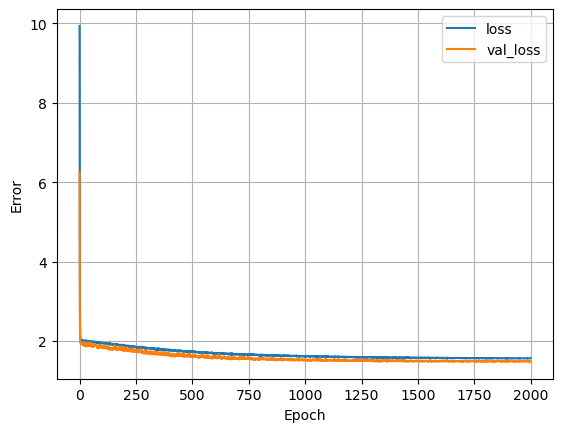

In [71]:
plot_loss(loss, val_loss)

Text(0.5, 1.0, 'predicted conditional variance')

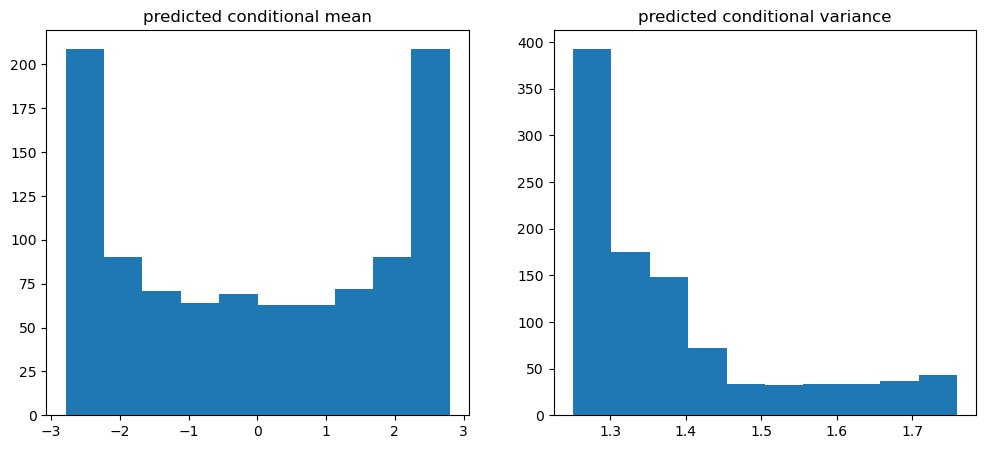

In [72]:
y_nn_3ml2_mu = model_ml2.predict(x_0_mat_3)[:,0]
pred_log_sigma = model_ml2.predict(x_0_mat_3)[:,1]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(y_nn_3ml2_mu)
plt.title('predicted conditional mean')
plt.subplot(1,2,2)
plt.hist(np.exp(pred_log_sigma)**2)
plt.title('predicted conditional variance')

In [73]:
def plot_with_ci(estimate, lower, upper, label):
    plot_fit(x_0, estimate, label, linewidth=0.5)
    plt.plot(x_0, lower, 'b', linewidth=0.5)
    plt.plot(x_0, upper, 'b', linewidth=0.5)
    plt.fill(np.concatenate([x_0, x_0[::-1]]),
             np.concatenate([lower,
                             upper[::-1]]), alpha=0.3, fc='lightskyblue', ec='None')

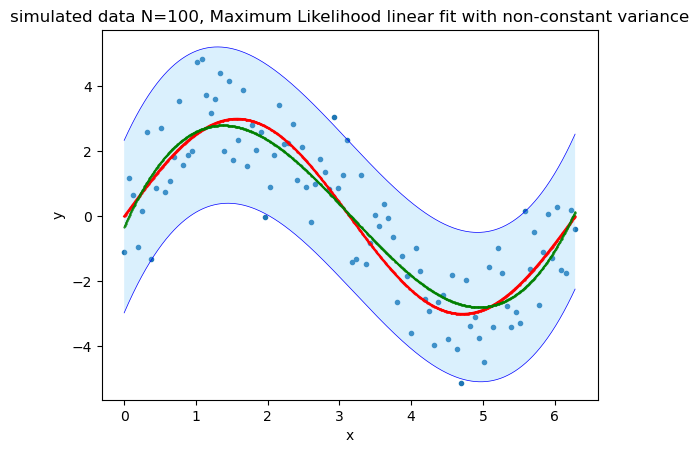

In [74]:
# show the fit plus/minus 2-times the standard deviation    
plot_with_ci(estimate = y_nn_3ml2_mu, 
             lower = y_nn_3ml2_mu - 2*(np.exp(pred_log_sigma)), 
             upper = y_nn_3ml2_mu + 2*(np.exp(pred_log_sigma)), 
             label = 'Maximum Likelihood linear fit with non-constant variance')

A model with non-constant variance **shows where the confidence interval is wide or narrow on the input space where the data is available.** This approach, **however, may not provide the correct information about the uncertainty in the input space where the data is sparse or non-existent.**  And, that is where a Bayesian approach comes in. 

### With small sample

In [75]:
# Repeat it for small sample 
# linear conditional mean from x, x^2, x^3
inputs = Input(shape=(3,))
out1 = keras.layers.Dense(1, batch_input_shape=(None,3), activation='linear')(inputs) 

# nonlinear conditional (log of) standard deviation from x, x^2, x^3 
hidden = keras.layers.Dense(4, activation = 'sigmoid')(inputs)
hidden = keras.layers.Dense(8, activation = 'sigmoid')(hidden)
hidden = keras.layers.Dense(4, activation = 'sigmoid')(hidden)
out2 = keras.layers.Dense(1, activation='linear')(hidden)

params = Concatenate()([out1, out2])
model_ml2_s = keras.Model(inputs=inputs, outputs=params)
#model_ml2_s.summary()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.25,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

model_ml2_s.compile(loss= NLL_loss_sigma, # <- Feeding the custom NLL function based on a ML formula
                  optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
                  metrics=[NLL_loss_sigma])

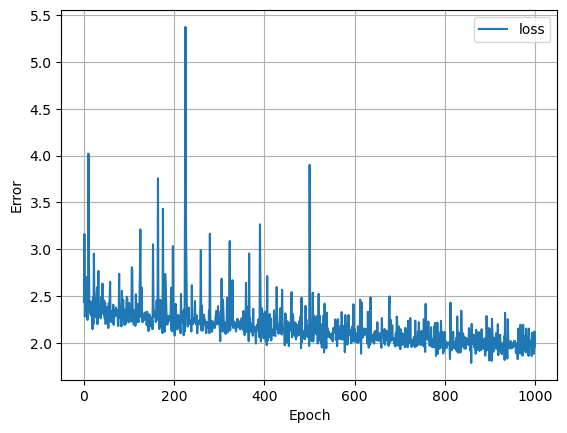

In [76]:
history = model_ml2_s.fit(x=xs_mat_3p, y=ysp, batch_size=1, epochs=1000, verbose = 0)
loss = history.history['loss']
plot_loss(loss)

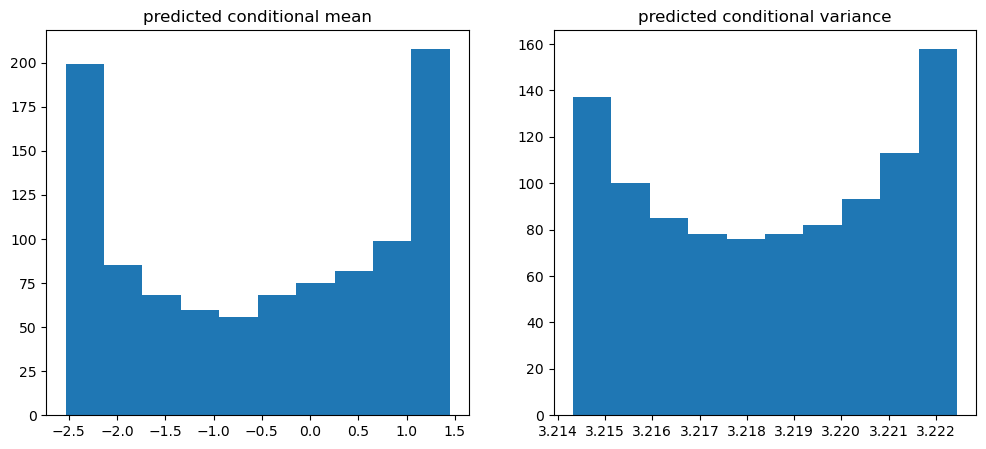

In [77]:
y_nn_3ml2_mu_s = model_ml2_s.predict(x_0_mat_3)[:,0]
pred_log_sigma_s = model_ml2_s.predict(x_0_mat_3)[:,1]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(y_nn_3ml2_mu_s)
plt.title('predicted conditional mean')
plt.subplot(1,2,2)
plt.hist(np.exp(pred_log_sigma_s)**2)
plt.title('predicted conditional variance');

In [78]:
def plot_with_ci_s(estimate, lower, upper, label):
    plot_fit_s(x_0, estimate, label, linewidth=0.5)
    plt.plot(x_0, lower, 'b', linewidth=0.5)
    plt.plot(x_0, upper, 'b', linewidth=0.5)
    plt.fill(np.concatenate([x_0, x_0[::-1]]),
             np.concatenate([lower,
                             upper[::-1]]), alpha=0.3, fc='lightskyblue', ec='None')

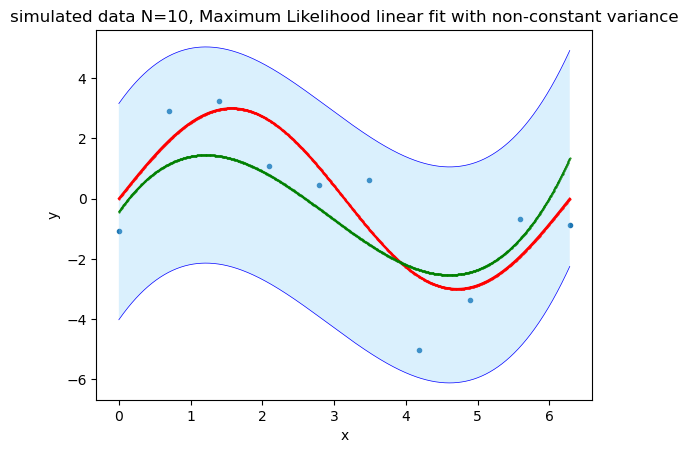

In [79]:
# show the fit plus/minus 2-times the standard deviation    
plot_with_ci_s(estimate = y_nn_3ml2_mu_s, 
             lower = y_nn_3ml2_mu_s - 2*(np.exp(pred_log_sigma_s)), 
             upper = y_nn_3ml2_mu_s + 2*(np.exp(pred_log_sigma_s)), 
             label = 'Maximum Likelihood linear fit with non-constant variance')

This may make sense. But the estimate varies with optimization conditions.  

## 7. Neural-Network Model fitting using Maximum Likelihood (Non-constant variance)

This time let's make everything **non-linear**, and **let the neural network decide** how to construct a nonlinear model.

In [80]:
# set up the model with 3 hidden layers and 2 output nodes
# This allows that the mean of the CPD depends non-linearly on x
# and also the (log of) standard deviation can depend non-linearly on x

model_ml3 = keras.models.Sequential([
    keras.layers.Dense(10, batch_input_shape=(None,1), activation = 'tanh'),
    keras.layers.Dense(20, activation = 'tanh'),
    keras.layers.Dense(10, activation= 'tanh'),
    keras.layers.Dense(2, activation='linear')
])

model_ml3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 10)                20        
_________________________________________________________________
dense_22 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_23 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 22        
Total params: 472
Trainable params: 472
Non-trainable params: 0
_________________________________________________________________


In [81]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.01,
    decay_steps=2000,
    decay_rate=0.95,
    staircase=True)

model_ml3.compile(loss= NLL_loss_sigma, # Feed the custom NLL function based on the ML formula above
                  optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
#                   optimizer=keras.optimizers.Adam(learning_rate = 0.0003), 
                  metrics=[NLL_loss_sigma])

In [82]:
loss, val_loss= [], []
history = model_ml3.fit(x=x_1p, y=yp, batch_size=1, epochs=2000, 
                verbose = 0, validation_split = 0.2)
loss, val_loss= history.history['loss'], history.history['val_loss']

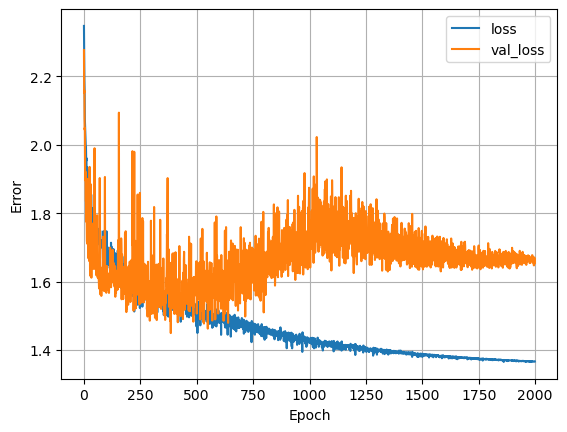

In [83]:
plot_loss(loss, val_loss)

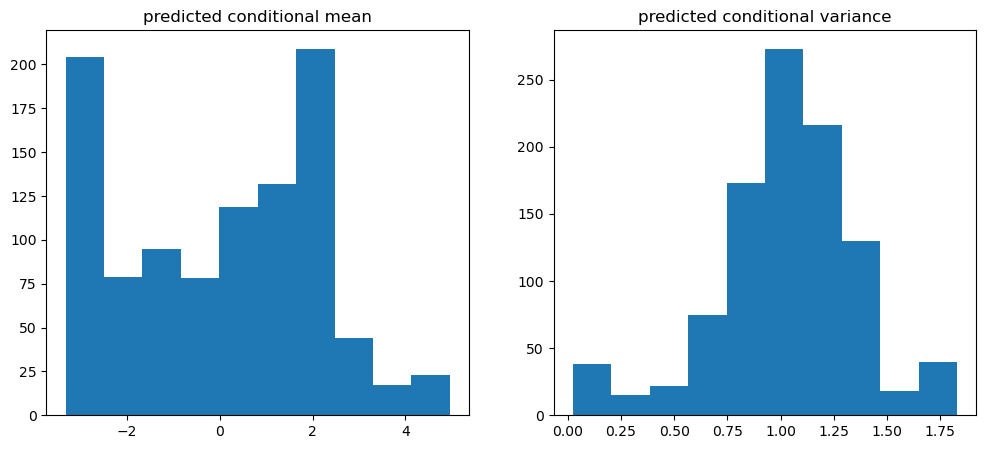

In [84]:
y_nn_3ml3_mu = model_ml3.predict(x_0)[:,0]
pred_log_sigma = model_ml3.predict(x_0)[:,1]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(y_nn_3ml3_mu)
plt.title('predicted conditional mean')
plt.subplot(1,2,2)
plt.hist(np.exp(pred_log_sigma)**2)
plt.title('predicted conditional variance');

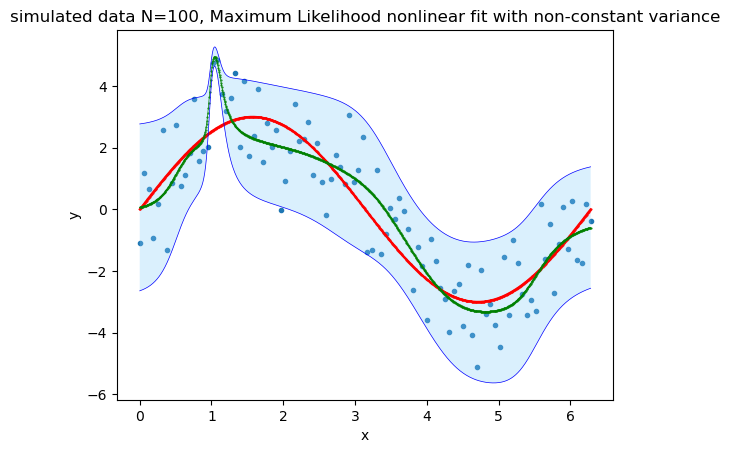

In [85]:
# show the fit plus/minus 2-times the standard deviation    
plot_with_ci(estimate = y_nn_3ml3_mu, 
             lower = y_nn_3ml3_mu - 2*(np.exp(pred_log_sigma)), 
             upper = y_nn_3ml3_mu + 2*(np.exp(pred_log_sigma)), 
             label = 'Maximum Likelihood nonlinear fit with non-constant variance')

This model learned the nonlinear conditional mean and variance from a single-dimensional input $x$.   

### With small sample

In [86]:
# add regularizers
l2_reg = keras.regularizers.l2(l2=0.01)

model_ml3_s = keras.models.Sequential([
    keras.layers.Dense(5, batch_input_shape=(None,1), activation = 'tanh', kernel_regularizer=l2_reg),
    keras.layers.Dense(10, activation = 'tanh', kernel_regularizer=l2_reg),
    keras.layers.Dense(5, activation='tanh', kernel_regularizer=l2_reg),
    keras.layers.Dense(2, activation='linear', kernel_regularizer=l2_reg)
])


# # try separate activation for mean and variance parameters
# # nonlinear conditional mean from x using tanh activation 
# inputs = Input(shape=(1,))
# hidden1 = keras.layers.Dense(3, activation = 'tanh', kernel_regularizer=l2_reg)(inputs)
# hidden1 = keras.layers.Dense(6, activation = 'tanh', kernel_regularizer=l2_reg)(hidden1)
# # hidden1 = keras.layers.Dense(3, activation = 'tanh', kernel_regularizer=l2_reg)(hidden1)
# out1 = keras.layers.Dense(1,  activation='linear')(hidden1) 

# # nonlinear conditional (log of) standard deviation from x using sigmoid activation 
# hidden2 = keras.layers.Dense(3, activation = 'sigmoid', kernel_regularizer=l2_reg)(inputs)
# # hidden2 = keras.layers.Dense(6, activation = 'sigmoid', kernel_regularizer=l2_reg)(hidden2)
# # hidden2 = keras.layers.Dense(2, activation = 'sigmoid', kernel_regularizer=l2_reg)(hidden2)
# out2 = keras.layers.Dense(1, activation='linear')(hidden2)

# params = Concatenate()([out1, out2])
# model_ml3_s = keras.Model(inputs=inputs, outputs=params)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.02,
    decay_steps=1000,
    decay_rate=0.92)

model_ml3_s.compile(loss= NLL_loss_sigma,
                  optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
                  metrics=[NLL_loss_sigma])

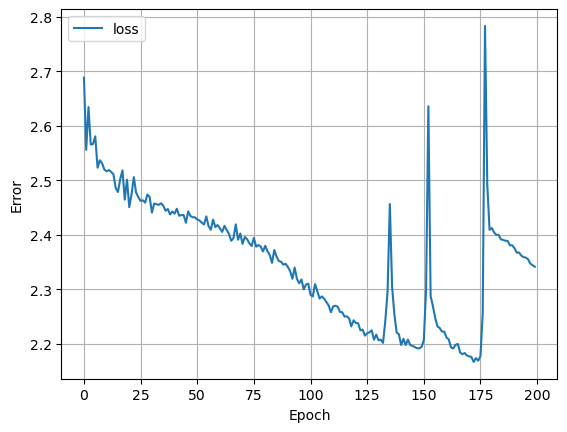

In [87]:
history = model_ml3_s.fit(x=xs_1p, y=ysp, batch_size=1, epochs=200, verbose = 0)
loss = history.history['loss']
plot_loss(loss)

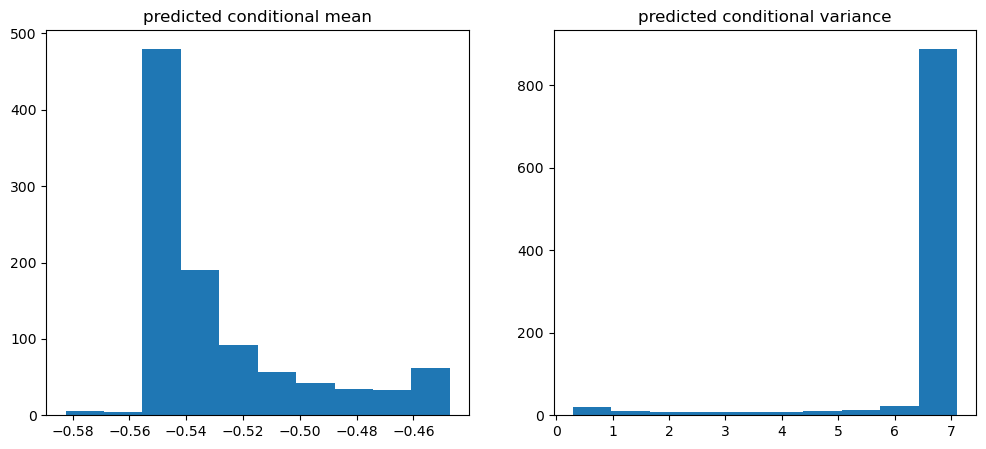

In [88]:
y_nn_3ml3_mu_s = model_ml3_s.predict(x_0)[:,0]
pred_log_sigma_s = model_ml3_s.predict(x_0)[:,1]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(y_nn_3ml3_mu_s)
plt.title('predicted conditional mean')
plt.subplot(1,2,2)
plt.hist(np.exp(pred_log_sigma_s)**2)
plt.title('predicted conditional variance');

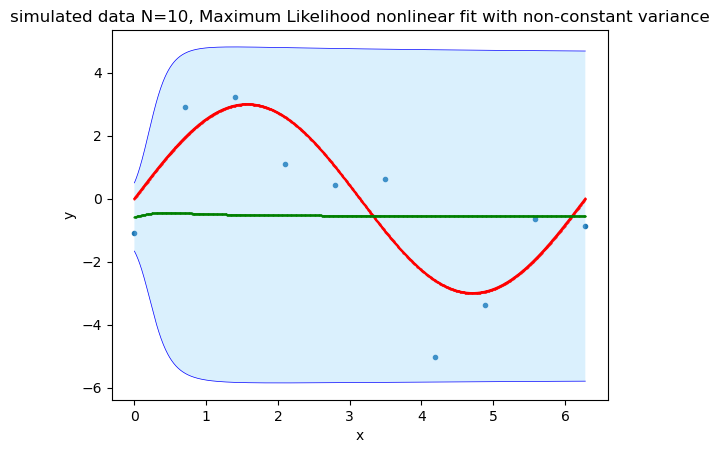

In [89]:
# show the fit plus/minus 2-times the standard deviation    
plot_with_ci_s(estimate = y_nn_3ml3_mu_s, 
             lower = y_nn_3ml3_mu_s - 2*(np.exp(pred_log_sigma_s)), 
             upper = y_nn_3ml3_mu_s + 2*(np.exp(pred_log_sigma_s)), 
             label = 'Maximum Likelihood nonlinear fit with non-constant variance')

With a small sample size, this model may be difficult to train. **The results are pretty sensitive to training conditions.** 


We will come back to this using a Bayesian approach (while I am not sure if it can help much in this case). 

Does using GradientTape to design a custom training loop help? 


## 7.2 Try GradientTape/Eager training 

In [90]:
# add regularizer
l2_reg = keras.regularizers.l2(l2=0.005)

model_ml4 = keras.models.Sequential([
    keras.layers.Dense(10, batch_input_shape=(None,1), activation = 'tanh', kernel_regularizer=l2_reg),
    keras.layers.Dense(20, activation = 'tanh', kernel_regularizer=l2_reg),
    keras.layers.Dense(10, activation= 'tanh', kernel_regularizer=l2_reg),
    keras.layers.Dense(2, activation='linear')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.002,
    decay_steps=20000,
    decay_rate=0.95,
    staircase=True)


# code is mostly copied from Ch 12 of Geron's book 
def print_status_bar(i, total, loss, metrics=None, vals=None):
    metrics = " ".join(['{}:{:.4f}'.format(m.name, m.result()) for m in [loss] + (metrics or []) + (vals or [])])
    end = "" if i < total else '\n'
    tf.print("\r{}/{} ".format(i, total) + metrics, end=end)
    
def random_batch(X, y, size=32):
    idx = np.random.randint(len(X), size=size)
    return tf.X[idx], y[idx]

def tf_random_batch(X_tf, y_tf, size=32):
    idx =  tf.random.uniform(shape=(size,1), minval=1, maxval=X_tf.shape[0], dtype=tf.int32) 
    return tf.gather(X_tf, idx), tf.gather(y_tf, idx)
    
n_epochs = 20000
batch_size = 1
n_steps = len(x_1p) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.002)
# optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
loss_fn = NLL_loss_sigma
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanSquaredError()]


In [91]:
# "Draft" before using decorator to compile into tf.function 
# # Convert data to tf variable 
# x_tf = tf.Variable(x_1p.reshape([len(x_1p),1]), dtype=tf.float32, trainable=False)
# y_tf = tf.Variable(yp.reshape([len(yp),1]), dtype=tf.float32, trainable=False) 

# for i in range(n_epochs):
#     if ((i+1) % 10 == 0):
#         print("Epoch {}/{}".format(i,n_epochs))
        
#     for b in range(n_steps):
#         # Take a random batch
#         x_b, y_b = tf_random_batch(x_tf, y_tf, batch_size)
        
#         # Define GradientTape and loss
#         with tf.GradientTape() as tape:
#             y_pred = model_ml4(x_b, training=True)
#             main_loss = tf.reduce_mean(loss_fn(y_b, y_pred))
#             loss = tf.add_n([main_loss] + model_ml4.losses)
        
#         # Calculate gradients
#         gradients = tape.gradient(loss, model_ml4.trainable_variables)

#         # Apply gradients
#         optimizer.apply_gradients(zip(gradients, model_ml4.trainable_variables))
        
#         # Calculate mean loss and metrics
#         mean_loss(loss)
#         for m in [mean_loss] + metrics: 
#             m(y_b, y_pred)
    
#         # Print progress 
#         if ((i+1) % 10 == 0):
#             print_status_bar((b+1) * batch_size, y_tf.shape[0], mean_loss, metrics)
            
#     for m in [mean_loss] + metrics: 
#         m.reset_states() 


In [92]:
# Use decorator to speed up

# Convert data to tf variable 
x_tf = tf.Variable(x_1p.reshape([len(x_1p),1]), dtype=tf.float32, trainable=False)
y_tf = tf.Variable(yp.reshape([len(yp),1]), dtype=tf.float32, trainable=False) 
        
@tf.function 
def train_step():
    #for b in tf.range(n_steps):  # <- not sure if we need this. It works without it and is faster without?
    # Take a random batch
    x_b, y_b = tf_random_batch(x_tf, y_tf, batch_size)

    # Define GradientTape and loss
    y_pred = model_ml4(x_b, training=True)
    main_loss = tf.reduce_mean(loss_fn(y_b, y_pred))
    loss = tf.add_n([main_loss] + model_ml4.losses)

    # Calculate gradients
    gradients = tape.gradient(loss, model_ml4.trainable_variables)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model_ml4.trainable_variables))

    # Calculate mean loss and metrics
    mean_loss(loss)
    for m in [mean_loss] + metrics: 
        m(y_b, y_pred[:,0])

for i in range(n_epochs):
    with tf.GradientTape(persistent=True) as tape: # Record the gradients from now on
        train_step()
    
        # Print progress 
        if ((i+1) % 10 == 0):
            print_status_bar((i+1), n_epochs, mean_loss, metrics)
            
    for m in [mean_loss] + metrics: 
        m.reset_states() 
                       

20000/20000 mean:3.5574 mean_squared_error:2.0673320


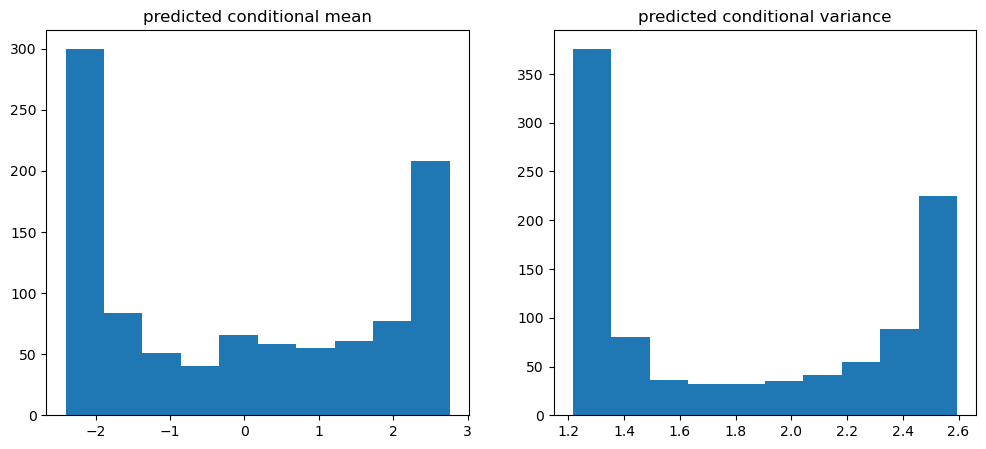

In [93]:
y_ml4 =  model_ml4(tf.Variable(x_0.reshape([len(x_0),1]), dtype=tf.float32))
y_ml4_mu = y_ml4[:,0].numpy()
y_ml4_log_sigma = y_ml4[:,1].numpy()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(y_ml4_mu)
plt.title('predicted conditional mean')
plt.subplot(1,2,2)
plt.hist(np.exp(y_ml4_log_sigma)**2)
plt.title('predicted conditional variance');

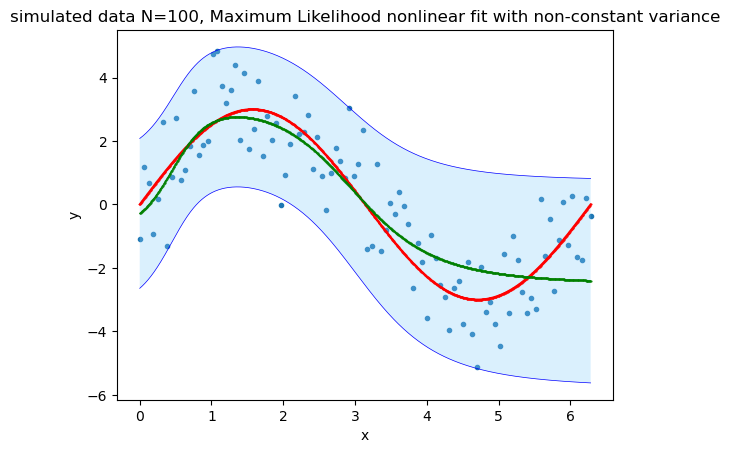

In [94]:
# show the fit plus/minus 2-times the standard deviation    
plot_with_ci(estimate = y_ml4_mu, 
             lower = y_ml4_mu - 2*(np.exp(y_ml4_log_sigma)), 
             upper = y_ml4_mu + 2*(np.exp(y_ml4_log_sigma)), 
             label = 'Maximum Likelihood nonlinear fit with non-constant variance')

Looks like it worked okay...

### With small sample

In [95]:
# try separate activation for mean and variance parameters

l2_reg = keras.regularizers.l2(l2=0.005)

model_ml4_s = keras.models.Sequential([
    keras.layers.Dense(5, batch_input_shape=(None,1), activation = 'tanh', kernel_regularizer=l2_reg),
    keras.layers.Dense(10, activation = 'tanh', kernel_regularizer=l2_reg),
    keras.layers.Dense(5, activation='tanh', kernel_regularizer=l2_reg),
    keras.layers.Dense(2, activation='linear')
])

# either model specification seems to work 

# # nonlinear conditional mean from x using tanh activation 
# inputs = Input(shape=(1,))
# hidden1 = keras.layers.Dense(3, activation = 'tanh', kernel_regularizer=l2_reg)(inputs)
# hidden1 = keras.layers.Dense(2, activation = 'tanh', kernel_regularizer=l2_reg)(hidden1)
# out1 = keras.layers.Dense(1,  activation='linear')(hidden1) 

# # nonlinear conditional (log of) standard deviation from x using sigmoid activation 
# hidden2 = keras.layers.Dense(3, activation = 'sigmoid', kernel_regularizer=l2_reg)(inputs)
# hidden2 = keras.layers.Dense(2, activation = 'sigmoid', kernel_regularizer=l2_reg)(hidden2)
# out2 = keras.layers.Dense(1, activation='linear')(hidden2)

# params = Concatenate()([out1, out2])
# model_ml4_s = keras.Model(inputs=inputs, outputs=params)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.004,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

n_epochs = 1000
batch_size = 1
n_steps = len(xs_1p) // batch_size
# optimizer = keras.optimizers.Nadam(learning_rate=0.002)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
loss_fn = NLL_loss_sigma
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanSquaredError()]

In [96]:
# Repeat for the small sample case: just replace x, y, model_label 
# Use decorator to speed up

# Convert data to tf variable 
xs_tf = tf.Variable(xs_1p.reshape([len(xs_1p),1]), dtype=tf.float32, trainable=False)
ys_tf = tf.Variable(ysp.reshape([len(ysp),1]), dtype=tf.float32, trainable=False) 
        
@tf.function 
def train_step():
    # Take a random batch
    x_b, y_b = tf_random_batch(xs_tf, ys_tf, batch_size)

    # Define GradientTape and loss
    y_pred = model_ml4_s(x_b, training=True)
    main_loss = tf.reduce_mean(loss_fn(y_b, y_pred))
    loss = tf.add_n([main_loss] + model_ml4_s.losses)

    # Calculate gradients
    gradients = tape.gradient(loss, model_ml4_s.trainable_variables)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model_ml4_s.trainable_variables))

    # Calculate mean loss and metrics
    mean_loss(loss)
    for m in [mean_loss] + metrics: 
        m(y_b, y_pred[:,0])

for i in range(n_epochs):
    with tf.GradientTape(persistent=True) as tape: # Record the gradients from now on
        train_step()
    
        # Print progress 
        if ((i+1) % 10 == 0):
            print_status_bar((i+1), n_epochs, mean_loss, metrics)
            
    for m in [mean_loss] + metrics: 
        m.reset_states() 
                       

1000/1000 mean:2.9547 mean_squared_error:2.21632


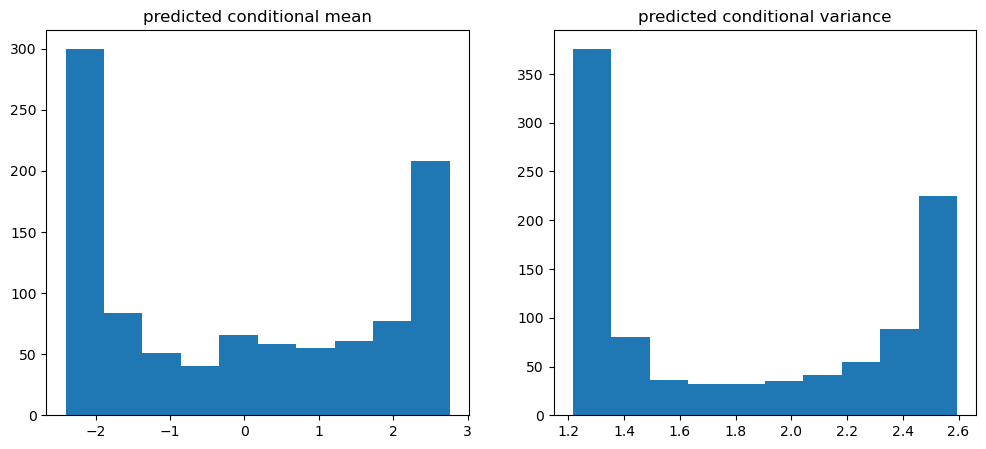

In [97]:
y_ml4_s =  model_ml4_s(tf.Variable(x_0.reshape([len(x_0),1]), dtype=tf.float32))
y_ml4_s_mu = y_ml4[:,0].numpy()
y_ml4_s_log_sigma = y_ml4[:,1].numpy()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(y_ml4_s_mu)
plt.title('predicted conditional mean')
plt.subplot(1,2,2)
plt.hist(np.exp(y_ml4_s_log_sigma)**2)
plt.title('predicted conditional variance');

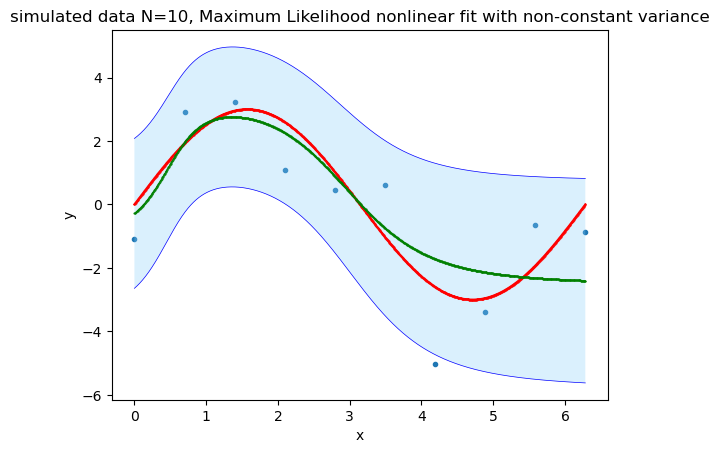

In [98]:
# show the fit plus/minus 2-times the standard deviation    
plot_with_ci_s(estimate = y_ml4_s_mu, 
             lower = y_ml4_s_mu - 2*(np.exp(y_ml4_s_log_sigma)), 
             upper = y_ml4_s_mu + 2*(np.exp(y_ml4_s_log_sigma)), 
             label = 'Maximum Likelihood nonlinear fit with non-constant variance')

It worked!?  To be honest, I am not sure why.

## 8. Conditional Probability Distribution Modeling with TFP

Previously, we looked at **linear models** to directly estimate linear parameters (slope [$a1$, $a2$, $a3$] and intercept $b$) for inputs [$x$, $x^2$, $x^3$] using **a single dense layer with a linear activation function** using either **the mean square error loss function** or **a custom negative log-likelihood (NLL) loss function**. 

We also reviewed using **Neural Networks** to specify **nonlinear models**.

Another technique was to specify **non-constant, conditional variance** via a custom NLL function.     
This type of model is capable of estimating **conditional mean $\mu_x $ and variance $\sigma_x$  given input $x$.**

Next, we turn to estimating **the conditional probability distribution of $y$ given $x$**, or $p(y|x)$. 

For example, we can estimate a model with **a Gaussian distribution** $p(y|x) = N(\mu_x,\sigma_x)$. 
This is **conceptually equivalent** to the previous model of **a Gaussian distribution with conditional variance** based on the maximum likelihood approach. This time, however, we use **a Tensorflow Probability's distribution layer** to specify the output that represents the conditional mean and variance given input. 

As a result, procedurally the model estimation will differ in the following ways:  

- We don't need  a complicated custom NLL function to tell how to translate parameters of $\mu_x$, $log(\sigma_x)$ into NLL. 
- Training will use random draws from the current estimate of $p(y|x)$, compare it to observed $y$, and accordingly construct NLL. 



\# Note: the code below is mostly borrowed from notebook `nb_ch08_03` if you want to review the source. 

In [99]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Specify a target Gaussian distribution as a function of estimated parameters in the final layer
def normal_sp(params): # sp = softplus version 
    return tfd.Normal(loc=params[:,0:1], 
                      scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2])) # scale needs to be positive

# Feed the target variable/data y into the target distributon and convert it to a negative log likelihood 
def dist_NLL(y, distr): 
    return - distr.log_prob(y) 

# Specify Keras model with 3 hidden layers and 2 output nodes  
# Nest named layers to build sequential layers (as opposed to using keras.models.Sequential), 
# which allows us to add tfp.layers.DistributionLambda in the final layer 
inputs = Input(shape=(1,))
hidden1 = Dense(10, activation="tanh")(inputs)
hidden2 = Dense(20,activation="tanh")(hidden1)
hidden3 = Dense(10,activation="tanh")(hidden2)
params = Dense(2)(hidden3)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 
               
model_nobay = Model(inputs=inputs, outputs=dist)
model_nobay.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_37 (Dense)             (None, 10)                20        
_________________________________________________________________
dense_38 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_39 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 22        
_________________________________________________________________
distribution_lambda (Distrib multiple                  0         
Total params: 472
Trainable params: 472
Non-trainable params: 0
_____________________________________________________________

In [100]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.02,
    decay_steps=2000,
    decay_rate=0.96,
    staircase=True)


model_nobay.compile(loss = dist_NLL, 
#                     optimizer = Adam()
                     optimizer=keras.optimizers.SGD(learning_rate=lr_schedule))
                  

In [101]:
### Training takes some time
history = model_nobay.fit(x_1p, yp, epochs=2000, verbose=0, batch_size=1, validation_split = 0.2)
loss = history.history['loss']
val_loss = history.history['val_loss']

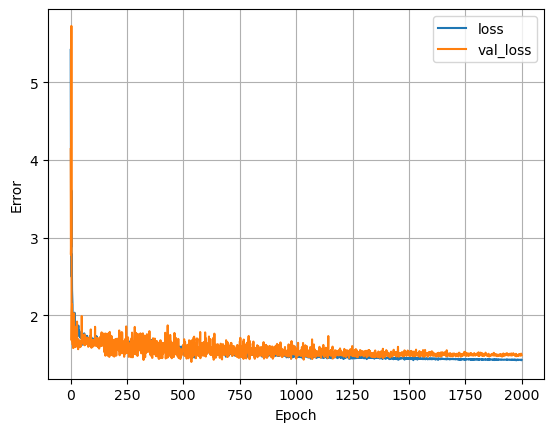

In [102]:
plot_loss(loss, val_loss)

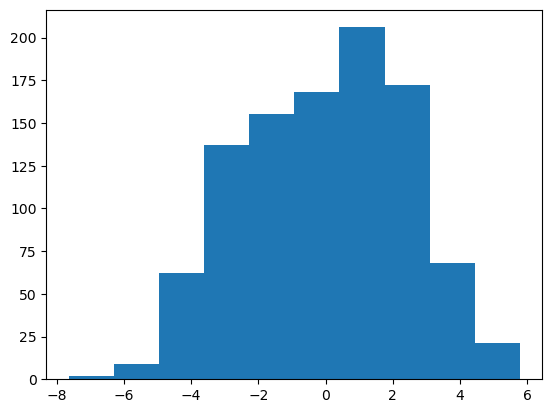

In [103]:
nobay_pred = model_nobay.predict(x_0)
plt.hist(nobay_pred)
plt.show()

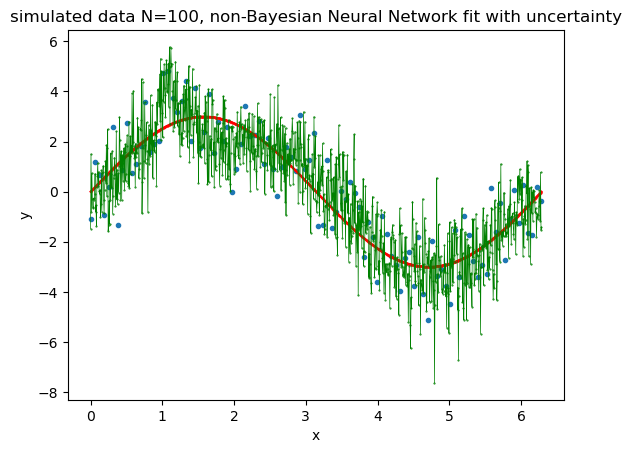

In [104]:
plot_fit(x_0, nobay_pred, 'non-Bayesian Neural Network fit with uncertainty', linewidth=.5)

Why does it look so unstable? 

It is because the prediction is generated by sampling from the Gaussian distribution as specified in the final layer. All the weights in the network are fixed, but the random draws from the fixed-parameter Gaussian is different for each time for a given input.  

If we repeat draws, we get different predictions and calculate the summary distribution for each input data point. 

In [105]:
for rep in range(2): #Predictions for two runs
    print(model_nobay.predict(x_0)[0:5].T) 

[[-2.520842    0.28834835  0.30255803  0.37484798 -0.24384704]]
[[-0.4268877  -0.01490124 -0.40701032  0.6394164  -0.00725539]]


To summarize the results, we take the average of, say, 200 draws and also calculate 2.5% and 97.5% percentiles for a 95-percent confidence interval. 

In [106]:
runs = 200
nobay_cpd =np.zeros((runs,len(x_0)))
for i in range(runs):
    nobay_cpd[i,:]=np.reshape(model_nobay.predict(x_0),len(x_0))

In [107]:
# summarize over multiple runs
np.quantile(nobay_cpd, 0.25, axis=0)[0:10]

array([-0.61030471, -0.60404493, -0.73180443, -0.79436122, -0.80449069,
       -0.67077424, -0.59542926, -0.80452114, -0.47533388, -0.72322714])

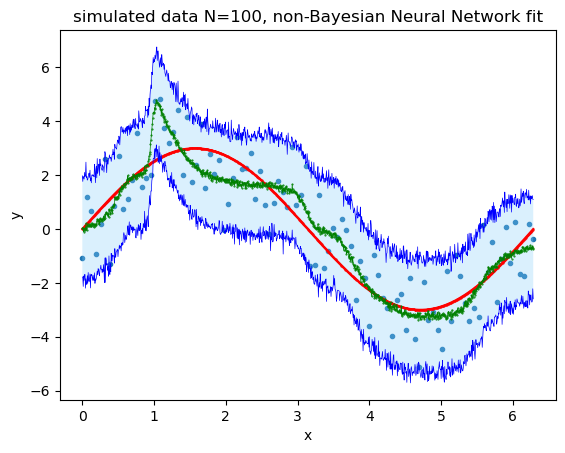

In [108]:
plot_with_ci(estimate = np.mean(nobay_cpd, axis=0), 
             lower = np.quantile(nobay_cpd, .025, axis=0),
             upper = np.quantile(nobay_cpd, .975, axis=0), 
             label = 'non-Bayesian Neural Network fit')

### With small sample

In [109]:
l2_reg = keras.regularizers.l2(l2=0.005)
 
inputs = Input(shape=(1,)) 
hidden = Dense(3, activation="tanh", kernel_regularizer=l2_reg)(inputs)
hidden = Dense(5,activation="tanh",  kernel_regularizer=l2_reg)(hidden)
params = Dense(2)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 
               
model_nobay_s = Model(inputs=inputs, outputs=dist)
# model_nobay_s.summary()

        

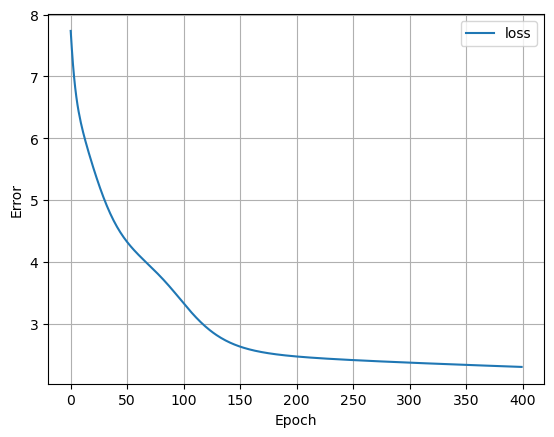

In [110]:
clr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.08,
    decay_steps=200,
    decay_rate=0.95)

model_nobay_s.compile(loss = dist_NLL, 
#                     optimizer = Adam()
                     optimizer=keras.optimizers.SGD(learning_rate=lr_schedule))
     
        
cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, 
                                                     restore_best_weights=True)

history = model_nobay_s.fit(xs_1p, ysp, epochs=400, verbose=0, 
                            batch_size=10, callbacks=[cb_early_stopping])
loss = history.history['loss']
plot_loss(loss)

In [111]:
runs = 50
nobay_s_cpd =np.zeros((runs,len(x_0)))
for i in range(runs):
    nobay_s_cpd[i,:]=np.reshape(model_nobay_s.predict(x_0),len(x_0))

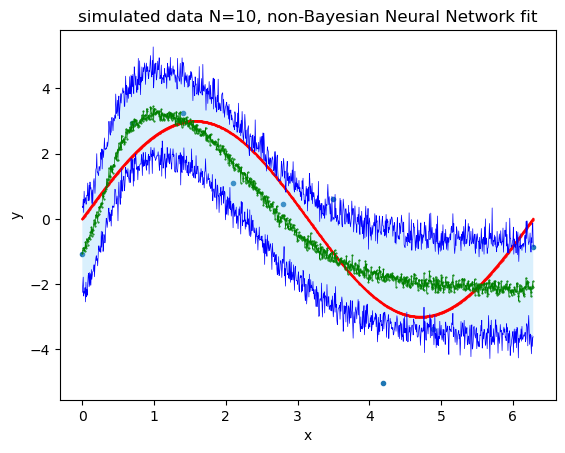

In [112]:
plot_with_ci_s(estimate = np.mean(nobay_s_cpd, axis=0), 
             lower = np.quantile(nobay_s_cpd, .025, axis=0),
             upper = np.quantile(nobay_s_cpd, .975, axis=0), 
             label = 'non-Bayesian Neural Network fit')

Not too bad...

## 8.2 Try GradientTape/Eager training

Let's try:
- Split training weights into conditional mean and conditional variance components
- Give them separate optimizers and learning rates
- Delay the training of conditional variance component by a certain number of iterations 

In [113]:
def print_status_bar2(i, i_total, metrics=None, vals=None):
    metrics = " ".join(['{}:{:.4f}'.format(m.name, m.result()) for m in (metrics or []) + (vals or [])])
    end = "" if i < i_total else '\n'
    tf.print("\r{}/{} ".format(i, i_total) + metrics, end=end)


def gen_eager_step_two_outs(model, model_out1, model_out2, loss_fn, optimizer1,  optimizer2):
    
#     @tf.function ## <- replaced with tf.function() 
    def eager_step_two_outs(epoch, x, y, batch_size=1, 
                            metrics =[], params_track=[],
                            train_out1_start=0, train_out2_start=0):
        '''
        Train model with two output components out1 and out2 with two separate optimizers 
        and optionally delay training of out1 or out2 by a fixed number of epochs 
        ''' 
        n_steps = tf.shape(x)[0] // batch_size           

        with tf.GradientTape(persistent=True) as tape: 
            for b in tf.range(n_steps):    
                # Take a random batch
                x_b, y_b = tf_random_batch(x, y, batch_size)

                # Define loss
                y_pred = model(x_b, training=True)
                main_loss = tf.reduce_mean(loss_fn(y_b, y_pred))
                loss = tf.add_n([main_loss] + model.losses)

                # Calculate gradients
                gradients1 = tape.gradient(loss, model_out1.trainable_variables)
                gradients2 = tape.gradient(loss, model_out2.trainable_variables)

                # Apply gradients
                if (epoch >= train_out1_start):
                    optimizer1.apply_gradients(zip(gradients1, model_out1.trainable_variables))
                if (epoch >= train_out2_start):
                    optimizer2.apply_gradients(zip(gradients2, model_out2.trainable_variables))               

                # Calculate mean loss and metrics: these are cumulative until being reset 
                for m in metrics: 
                    m(y_b, y_pred[:,0])
                for p in params_track:
                    p(y_pred.parameters.get(p.name))
                    
    return tf.function(eager_step_two_outs)


def eager_train_steps(tf_eager_func, n_epochs, x, y, batch_size=1, 
                    metrics =[], params_track=[], **kwargs):
    # pass a tf variable representing epoch iteration to train_step()        
    epoch = tf.Variable(0, trainable=False)
    
    for i in range(n_epochs):
        tf_eager_func(
            epoch, x, y, batch_size, 
            metrics, params_track, **kwargs)

        # Print progress 
        if ((i+1) % 100 == 0):
            print_status_bar2((i+1), n_epochs, metrics, params_track)

        # Reset metrics and params_track 
        for m in metrics: 
            m.reset_states() 
        for p in params_track:
            p.reset_states()

        epoch.assign_add(1)

In [114]:
l2_reg1 = keras.regularizers.l2(l2=0.05)
l2_reg2 = keras.regularizers.l2(l2=0.1)

# nonlinear conditional mean from x using tanh activation 
inputs = Input(shape=(1,))
hidden1 = keras.layers.Dense(10, activation = 'tanh', kernel_regularizer=l2_reg1)(inputs)
hidden1 = keras.layers.Dense(20, activation = 'tanh', kernel_regularizer=l2_reg1)(hidden1)
hidden1 = keras.layers.Dense(10, activation = 'tanh', kernel_regularizer=l2_reg1)(hidden1)
out1 = keras.layers.Dense(1,  activation='linear', kernel_regularizer=l2_reg1)(hidden1) 

# nonlinear conditional (log of) standard deviation from x using sigmoid activation 
hidden2 = keras.layers.Dense(10, activation = 'sigmoid', kernel_regularizer=l2_reg2)(inputs)
hidden2 = keras.layers.Dense(20, activation = 'sigmoid', kernel_regularizer=l2_reg2)(hidden2)
hidden2 = keras.layers.Dense(10, activation = 'sigmoid', kernel_regularizer=l2_reg2)(hidden2)
out2 = keras.layers.Dense(1, activation='linear', kernel_regularizer=l2_reg2)(hidden2)

params = Concatenate()([out1, out2])
dist = tfp.layers.DistributionLambda(normal_sp)(params) 
model_nobay2_out1 = keras.Model(inputs=inputs, outputs=out1)
model_nobay2_out2 = keras.Model(inputs=inputs, outputs=out2)
model_nobay2 = keras.Model(inputs=inputs, outputs=dist)

In [115]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0004,
    decay_steps=500,
    decay_rate=0.96,
    staircase=True)

tf_step_two_outs_nobay2 = gen_eager_step_two_outs(
                            model = model_nobay2,
                            model_out1 = model_nobay2_out1,
                            model_out2 = model_nobay2_out2,
                            loss_fn = dist_NLL,
                            optimizer1 = keras.optimizers.SGD(learning_rate=lr_schedule),
                            optimizer2 = keras.optimizers.Nadam(learning_rate=0.001))


# Convert data to tf variable 
x_tf = tf.Variable(x_1p.reshape([len(x_1p),1]), dtype=tf.float32, trainable=False)
y_tf = tf.Variable(yp.reshape([len(yp),1]), dtype=tf.float32, trainable=False) 
        
    
# For the medium sample, usee: x_tf, y_tf 
eager_train_steps(
    tf_eager_func = tf_step_two_outs_nobay2, 
    n_epochs = 2000, 
    x = x_tf,  
    y = y_tf, 
    batch_size = 1, 
    train_out1_start=1, 
    train_out2_start=1500, 
    metrics =[keras.metrics.MeanSquaredError()], 
    params_track=[keras.metrics.Mean(name='scale')])

2000/2000 mean_squared_error:3.8609 scale:1.2106


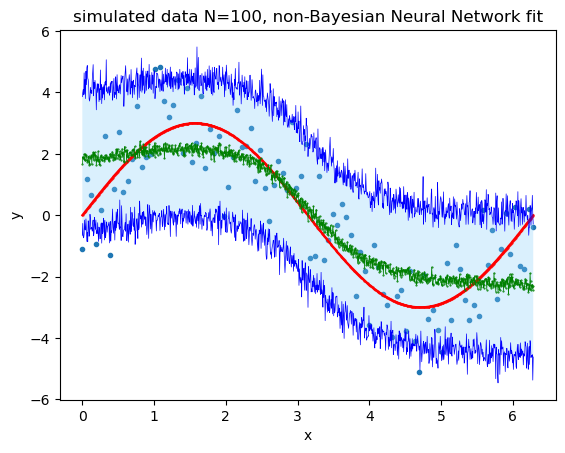

In [116]:
runs = 100
nobay2_cpd =np.zeros((runs,len(x_0)))
for i in range(runs):
    nobay2_cpd[i,:]=np.reshape(model_nobay2.predict(x_0),len(x_0))
    
plot_with_ci(estimate = np.mean(nobay2_cpd, axis=0), 
             lower = np.quantile(nobay2_cpd, .025, axis=0),
             upper = np.quantile(nobay2_cpd, .975, axis=0), 
             label = 'non-Bayesian Neural Network fit')

hmm...not necessarily better.

### With Small Sample

In [117]:
l2_reg1 = keras.regularizers.l2(l2=0.05)
l2_reg2 = keras.regularizers.l2(l2=0.1)

# nonlinear conditional mean from x using tanh activation 
inputs = Input(shape=(1,))
hidden1 = keras.layers.Dense(3, activation = 'tanh', kernel_regularizer=l2_reg1)(inputs)
hidden1 = keras.layers.Dense(5, activation = 'tanh', kernel_regularizer=l2_reg1)(hidden1)
# hidden1 = keras.layers.Dense(2, activation = 'tanh', kernel_regularizer=l2_reg1)(hidden1)
out1 = keras.layers.Dense(1,  activation='linear', kernel_regularizer=l2_reg1)(hidden1) 

# nonlinear conditional (log of) standard deviation from x using sigmoid activation 
hidden2 = keras.layers.Dense(3, activation = 'sigmoid', kernel_regularizer=l2_reg2)(inputs)
hidden2 = keras.layers.Dense(5, activation = 'sigmoid', kernel_regularizer=l2_reg2)(hidden2)
# hidden2 = keras.layers.Dense(2, activation = 'sigmoid', kernel_regularizer=l2_reg2)(hidden2)
out2 = keras.layers.Dense(1, activation='linear', kernel_regularizer=l2_reg2)(hidden2)

params = Concatenate()([out1, out2])
dist = tfp.layers.DistributionLambda(normal_sp)(params) 
model_nobay2_s_out1 = keras.Model(inputs=inputs, outputs=out1)
model_nobay2_s_out2 = keras.Model(inputs=inputs, outputs=out2)
model_nobay2_s = keras.Model(inputs=inputs, outputs=dist)

In [118]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.01, decay_steps=1000, decay_rate=0.25)

tf_step_two_outs_nobay2_s = gen_eager_step_two_outs(
                            model = model_nobay2_s,
                            model_out1 = model_nobay2_s_out1,
                            model_out2 = model_nobay2_s_out2,
                            loss_fn =  dist_NLL,
                            optimizer1 = keras.optimizers.SGD(learning_rate=lr_schedule),
                            optimizer2 = keras.optimizers.Nadam(learning_rate=0.001))


# Convert data to tf variable 
xs_tf = tf.Variable(xs_1p.reshape([len(xs_1p),1]), dtype=tf.float32, trainable=False)
ys_tf = tf.Variable(ysp.reshape([len(ysp),1]), dtype=tf.float32, trainable=False)         

# For the small sample, use: xs_tf, ys_tf
eager_train_steps(
    tf_eager_func = tf_step_two_outs_nobay2_s, 
    n_epochs = 2000, 
    x = xs_tf,  
    y = ys_tf, 
    batch_size = 1, 
    train_out1_start=1, 
    train_out2_start=400, 
    metrics =[keras.metrics.MeanSquaredError()], 
    params_track=[keras.metrics.Mean(name='scale')])

2000/2000 mean_squared_error:2.2806 scale:0.9036


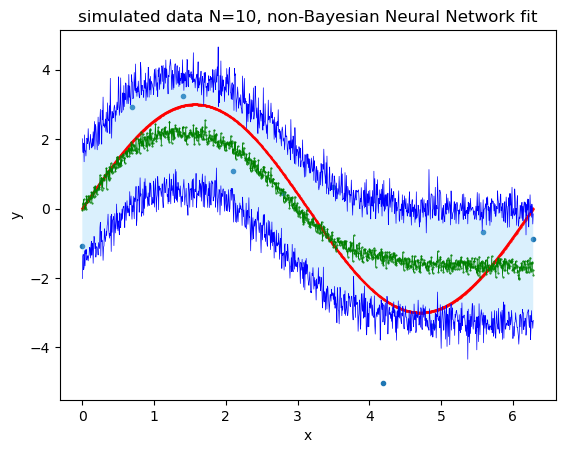

In [119]:
runs = 50
nobay2_s_cpd =np.zeros((runs,len(x_0)))
for i in range(runs):
    nobay2_s_cpd[i,:]=np.reshape(model_nobay2_s.predict(x_0),len(x_0))
    
plot_with_ci_s(estimate = np.mean(nobay2_s_cpd, axis=0), 
             lower = np.quantile(nobay2_s_cpd, .025, axis=0),
             upper = np.quantile(nobay2_s_cpd, .975, axis=0), 
             label = 'non-Bayesian Neural Network fit')

## 9. Bayesian Neural Network via Variational Inference

Now we train a Bayesian neural network (BNN) via variational inference (VI). Instead of directly estimating weights (i.e. parameters in each layers), we **approximate the posterior of the weights** with normal distributions. 

**The normal distribution** has **two paramters** and therefore, we have **approximately twice the number of non-Bayesian version's paramters**  (not exactly double because we don't use a distribution for bias terms). 

We can convert the non-Bayesian model above into a BNN-VI model by replacing Dense layers with **DenseFlipout layers**, which replaces fixed parameters with **parameter distributions** approximated using **KL divergence**.

In [120]:
# "bug" fix for KL divergence functions -- divide it by the number of data points -- as the authors mentioned
n_obs = x_1p.shape[0]
kernel_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (n_obs * 1.0) 
bias_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p)  / (n_obs * 1.0)


inputs = Input(shape=(1,))
hidden = tfp.layers.DenseFlipout(10,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn, activation="tanh")(inputs)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn, activation="tanh")(hidden)
hidden = tfp.layers.DenseFlipout(10,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn, activation="tanh")(hidden)
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 

model_vi = Model(inputs=inputs, outputs=dist)
model_vi.summary()

/opt/anaconda3/lib/python3.7/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 10)                40        
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 20)                440       
_________________________________________________________________
dense_flipout_2 (DenseFlipou (None, 10)                420       
_________________________________________________________________
dense_flipout_3 (DenseFlipou (None, 2)                 44        
_________________________________________________________________
distribution_lambda_4 (Distr multiple                  0         
Total params: 944
Trainable params: 944
Non-trainable params: 0
____________________________________________________________

In [121]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps=4000,
    decay_rate=0.96,
    staircase=True)

model_vi.compile(loss=dist_NLL, 
#                  optimizer=Adam(learning_rate=lr_schedule))
                optimizer=keras.optimizers.SGD(learning_rate=lr_schedule)) 

In [122]:
# this will take a while...
history = model_vi.fit(x_1p, yp, epochs=4000, verbose=0, batch_size=1,  validation_split = 0.2)
loss =  history.history['loss']
val_loss =  history.history['val_loss']

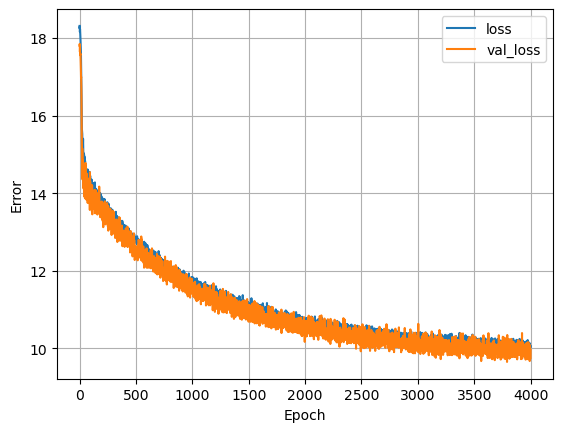

In [123]:
plot_loss(loss, val_loss)

In [124]:
# if you save a model, you can load it to restore estimated weights.

# model_vi.save_weights('model_vi.hdf5')
# model_vi.load_weights("model_vi.hdf5")

In [125]:
# look at the weights of a Flipout layer
model_vi.layers[4].get_weights()[1]

array([[-2.5450337, -2.206417 ],
       [-2.3094814, -2.0023685],
       [-2.4299636, -2.2277575],
       [-2.4201112, -2.0988889],
       [-2.261173 , -2.1297555],
       [-2.3375351, -2.210758 ],
       [-2.407929 , -2.0665941],
       [-2.3478508, -2.019156 ],
       [-2.3763237, -2.1224613],
       [-2.3307297, -2.0287719]], dtype=float32)

In [126]:
# Samples from the posteriori predictive distribution, different for each run
# because of the Flipout layers and the final Gaussian distribution layer 
    
for rep in range(2):
    print(model_vi.predict(x_0)[0:3].T) 

[[1.5660343 2.4925876 1.6491635]]
[[0.83426917 1.0246849  3.5694048 ]]


Now we sample mean $\mu$ and standard deviation $\sigma$. As in the previous model, each time we get a different prediction. This time, however, we have another source of uncertainty, namely the random draws of model layer weights.

In [127]:
#Samples from the parameters differ for each run
model_params = Model(inputs=inputs, outputs=params)
for rep in range(5):
    print(model_params.predict(x_0)[0:3].T) 

[[ 2.0905645  1.157501   2.1499572]
 [14.487776  14.881414  13.877998 ]]
[[ 2.003094  1.639413  1.775352]
 [14.94454  14.024405 14.132611]]
[[ 2.2838244  1.2760795  1.6750094]
 [14.845843  14.820731  13.45037  ]]
[[ 2.0285993  1.9376414  2.002664 ]
 [14.307655  14.282987  14.564909 ]]
[[ 1.8156409  2.087795   1.6421629]
 [13.316278  13.642812  13.488084 ]]


In [128]:
runs = 200
vi_cpd =np.zeros((runs,len(x_0)))
for i in range(runs):
    vi_cpd[i,:]=np.reshape(model_vi.predict(x_0),len(x_0))

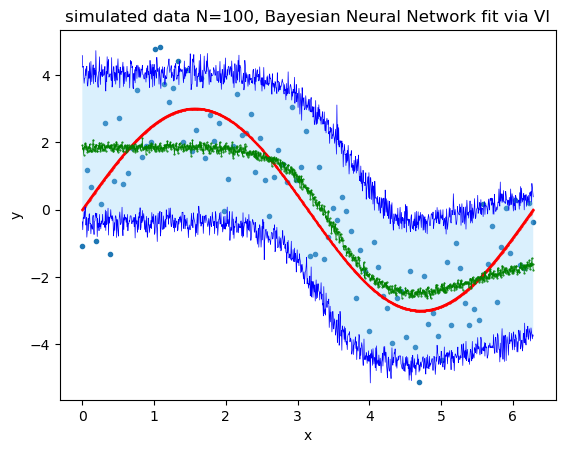

In [129]:
plot_with_ci(estimate = np.mean(vi_cpd, axis=0), 
             lower = np.quantile(vi_cpd, .025, axis=0),
             upper = np.quantile(vi_cpd, .975, axis=0),
             label = 'Bayesian Neural Network fit via VI')

\# *Try changing the model structures and optimizers to get a sense of how to train this BNN. To be honest, I don't really understand how to effectively select these and train the model.*  



### With small sample

In [130]:
# Repeat it for the samll sample 
n_obs = xs_1p.shape[0]  # small sample size
kernel_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (n_obs * 1.0) 
bias_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p)  / (n_obs * 1.0)

# l2_reg1 = keras.regularizers.l2(l2=0.05) # <- cannot use regularizer

inputs = Input(shape=(1,))
hidden = tfp.layers.DenseFlipout(3,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn, 
                           bias_divergence_fn=bias_divergence_fn, activation="tanh")(inputs)
hidden = tfp.layers.DenseFlipout(5,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn, activation="tanh")(hidden)
# hidden = tfp.layers.DenseFlipout(4,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
#                            bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
#                            kernel_divergence_fn=kernel_divergence_fn,
#                            bias_divergence_fn=bias_divergence_fn, activation="tanh")(hidden)
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 

model_vi_s = Model(inputs=inputs, outputs=dist)


/opt/anaconda3/lib/python3.7/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


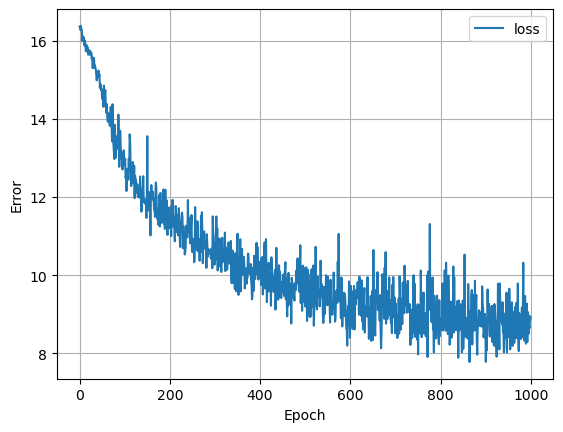

In [131]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.005,
    decay_steps=400,
    decay_rate=0.9)

model_vi_s.compile(loss=dist_NLL, 
#                  optimizer=Adam(learning_rate=lr_schedule))
                optimizer=keras.optimizers.SGD(learning_rate=lr_schedule)) 


history = model_vi_s.fit(xs_1p, ysp, epochs=1000, verbose=0, batch_size=1)
loss =  history.history['loss']
plot_loss(loss)

In [132]:
runs = 50
vi_s_cpd =np.zeros((runs,len(x_0)))
for i in range(runs):
    vi_s_cpd[i,:]=np.reshape(model_vi_s.predict(x_0),len(x_0))

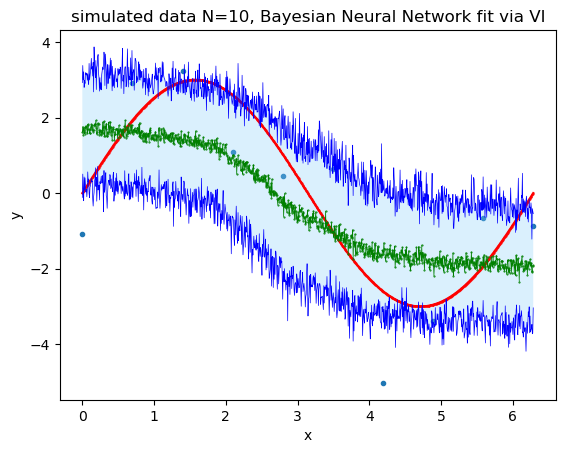

In [133]:
plot_with_ci_s(estimate = np.mean(vi_s_cpd, axis=0), 
             lower = np.quantile(vi_s_cpd, .025, axis=0),
             upper = np.quantile(vi_s_cpd, .975, axis=0),
             label = 'Bayesian Neural Network fit via VI')

hmm..

## 9.2 Training with GradientTape/Eager

In [134]:
n_obs = x_1p.shape[0]  # use small sample size when estimating with the small sample data 
kernel_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (n_obs * 1.0) 
bias_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p)  / (n_obs * 1.0)

# nonlinear conditional mean from x using tanh activation 
inputs = Input(shape=(1,))
hidden1 = tfp.layers.DenseFlipout(10, 
                bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                kernel_divergence_fn=kernel_divergence_fn,
                bias_divergence_fn=bias_divergence_fn, activation = 'tanh')(inputs)
hidden1 = tfp.layers.DenseFlipout(20, 
                bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                kernel_divergence_fn=kernel_divergence_fn,
                bias_divergence_fn=bias_divergence_fn, activation = 'tanh')(hidden1)
hidden1 = tfp.layers.DenseFlipout(10, 
                bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                kernel_divergence_fn=kernel_divergence_fn,
                bias_divergence_fn=bias_divergence_fn, activation = 'tanh')(hidden1)
out1 = tfp.layers.DenseFlipout(1, 
                bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                kernel_divergence_fn=kernel_divergence_fn,
                bias_divergence_fn=bias_divergence_fn, activation='linear')(hidden1) 

# nonlinear conditional (log of) standard deviation from x using sigmoid activation 
hidden2 = tfp.layers.DenseFlipout(10, 
                bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                kernel_divergence_fn=kernel_divergence_fn,
                bias_divergence_fn=bias_divergence_fn, activation = 'sigmoid')(inputs)
hidden2 = tfp.layers.DenseFlipout(20, 
                bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                kernel_divergence_fn=kernel_divergence_fn,
                bias_divergence_fn=bias_divergence_fn, activation = 'sigmoid')(hidden2)
hidden2 = tfp.layers.DenseFlipout(10, 
                bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                kernel_divergence_fn=kernel_divergence_fn,
                bias_divergence_fn=bias_divergence_fn, activation = 'sigmoid')(hidden2)
out2 = tfp.layers.DenseFlipout(1, 
                bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                kernel_divergence_fn=kernel_divergence_fn,
                bias_divergence_fn=bias_divergence_fn, activation = 'linear')(hidden2)

params = Concatenate()([out1, out2])
dist = tfp.layers.DistributionLambda(normal_sp)(params) 
model_vi2_out1 = keras.Model(inputs=inputs, outputs=out1)
model_vi2_out2 = keras.Model(inputs=inputs, outputs=out2)
model_vi2 = keras.Model(inputs=inputs, outputs=dist)

# fix the scale parameter till some number of itereations has reached 
len_out2_layers = len(model_vi2_out2.trainable_variables)
len_out2_inputs = len(model_vi2_out2.trainable_variables[len_out2_layers-4].numpy()) 
model_vi2_out2.trainable_variables[len_out2_layers-2].assign([-10.]) # last layer bias:loc
model_vi2_out2.trainable_variables[len_out2_layers-1].assign(tf.zeros(1)) # last layer bias:scale
model_vi2_out2.trainable_variables[len_out2_layers-4].assign(tf.zeros((len_out2_inputs,1))) # last layer weights: loc
model_vi2_out2.trainable_variables[len_out2_layers-3].assign(tf.zeros((len_out2_inputs,1))); # last layer weights: loc


/opt/anaconda3/lib/python3.7/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [135]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps=2000,
    decay_rate=0.96,
    staircase=True)

tf_step_two_outs_vi2 = gen_eager_step_two_outs(
                            model = model_vi2,
                            model_out1 = model_vi2_out1,
                            model_out2 = model_vi2_out2,
                            loss_fn = dist_NLL,
                            optimizer1 = keras.optimizers.SGD(learning_rate=lr_schedule),
                            optimizer2 = keras.optimizers.Nadam(learning_rate=0.001))

# For the medium sample, use: x_tf, y_tf 
eager_train_steps(
    tf_eager_func = tf_step_two_outs_vi2, 
    n_epochs = 1000, 
    x = x_tf,  
    y = y_tf, 
    batch_size = 1, 
    train_out1_start=1, 
    train_out2_start=500, 
    metrics =[keras.metrics.MeanSquaredError()], 
    params_track=[keras.metrics.Mean(name='scale')])

1000/1000 mean_squared_error:2.4841 scale:0.9443


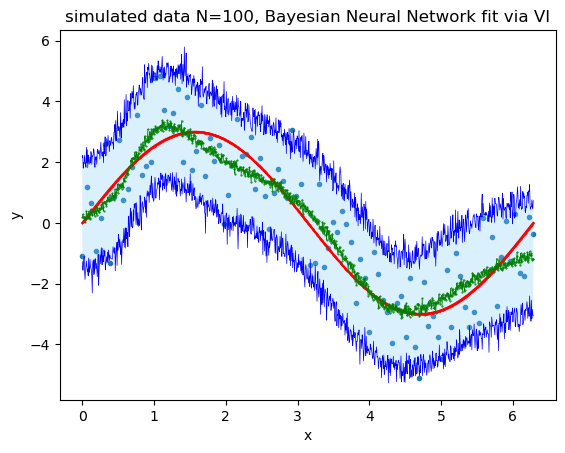

In [136]:
runs = 100
vi2_cpd =np.zeros((runs,len(x_0)))
for i in range(runs):
    vi2_cpd[i,:]=np.reshape(model_vi2.predict(x_0),len(x_0))
    

plot_with_ci(estimate = np.mean(vi2_cpd, axis=0), 
             lower = np.quantile(vi2_cpd, .025, axis=0),
             upper = np.quantile(vi2_cpd, .975, axis=0),
             label = 'Bayesian Neural Network fit via VI')

That may look pretty good.

### With Small Sample

In [137]:
n_obs = x_1p.shape[0]  # use small sample size when estimating with the small sample data 
kernel_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (n_obs * 1.0) 
bias_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p)  / (n_obs * 1.0)

# nonlinear conditional mean from x using tanh activation 
inputs = Input(shape=(1,))
hidden1 = tfp.layers.DenseFlipout(3, 
                bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                kernel_divergence_fn=kernel_divergence_fn,
                bias_divergence_fn=bias_divergence_fn, activation = 'tanh')(inputs)
hidden1 = tfp.layers.DenseFlipout(5, 
                bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                kernel_divergence_fn=kernel_divergence_fn,
                bias_divergence_fn=bias_divergence_fn, activation = 'tanh')(hidden1)
# hidden1 = tfp.layers.DenseFlipout(10, 
#                 bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
#                 bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
#                 kernel_divergence_fn=kernel_divergence_fn,
#                 bias_divergence_fn=bias_divergence_fn, activation = 'tanh')(hidden1)
out1 = tfp.layers.DenseFlipout(1, 
                bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                kernel_divergence_fn=kernel_divergence_fn,
                bias_divergence_fn=bias_divergence_fn, activation='linear')(hidden1) 

# nonlinear conditional (log of) standard deviation from x using sigmoid activation 
hidden2 = tfp.layers.DenseFlipout(3, 
                bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                kernel_divergence_fn=kernel_divergence_fn,
                bias_divergence_fn=bias_divergence_fn, activation = 'sigmoid')(inputs)
hidden2 = tfp.layers.DenseFlipout(5, 
                bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                kernel_divergence_fn=kernel_divergence_fn,
                bias_divergence_fn=bias_divergence_fn, activation = 'sigmoid')(hidden2)
# hidden2 = tfp.layers.DenseFlipout(10, 
#                 bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
#                 bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
#                 kernel_divergence_fn=kernel_divergence_fn,
#                 bias_divergence_fn=bias_divergence_fn, activation = 'sigmoid')(hidden2)
out2 = tfp.layers.DenseFlipout(1, 
                bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                kernel_divergence_fn=kernel_divergence_fn,
                bias_divergence_fn=bias_divergence_fn, activation = 'linear')(hidden2)

params = Concatenate()([out1, out2])
dist = tfp.layers.DistributionLambda(normal_sp)(params) 
model_vi2_s_out1 = keras.Model(inputs=inputs, outputs=out1)
model_vi2_s_out2 = keras.Model(inputs=inputs, outputs=out2)
model_vi2_s = keras.Model(inputs=inputs, outputs=dist)

# fix the scale parameter till some number of itereations has reached 
len_out2_layers = len(model_vi2_s_out2.trainable_variables)
len_out2_inputs = len(model_vi2_s_out2.trainable_variables[len_out2_layers-4].numpy()) 
model_vi2_s_out2.trainable_variables[len_out2_layers-2].assign([-10.]) # last layer bias:loc
model_vi2_s_out2.trainable_variables[len_out2_layers-1].assign(tf.zeros(1)) # last layer bias:scale
model_vi2_s_out2.trainable_variables[len_out2_layers-4].assign(tf.zeros((len_out2_inputs,1))) # last layer weights: loc
model_vi2_s_out2.trainable_variables[len_out2_layers-3].assign(tf.zeros((len_out2_inputs,1))); # last layer weights: loc


/opt/anaconda3/lib/python3.7/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [138]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.01,
    decay_steps=1000,
    decay_rate=0.25,
    staircase=True)

tf_step_two_outs_vi2 = gen_eager_step_two_outs(
                            model = model_vi2_s,
                            model_out1 = model_vi2_s_out1,
                            model_out2 = model_vi2_s_out2,
                            loss_fn = dist_NLL,
                            optimizer1 = keras.optimizers.SGD(learning_rate=lr_schedule),
                            optimizer2 = keras.optimizers.Nadam(learning_rate=0.001))

# For the small sample, use: xs_tf, ys_tf
eager_train_steps(
    tf_eager_func = tf_step_two_outs_vi2, 
    n_epochs = 1000, 
    x = xs_tf,  
    y = ys_tf, 
    batch_size = 1, 
    train_out1_start=1, 
    train_out2_start=200, 
    metrics =[keras.metrics.MeanSquaredError()], 
    params_track=[keras.metrics.Mean(name='scale')])

1000/1000 mean_squared_error:1.2449 scale:1.0255


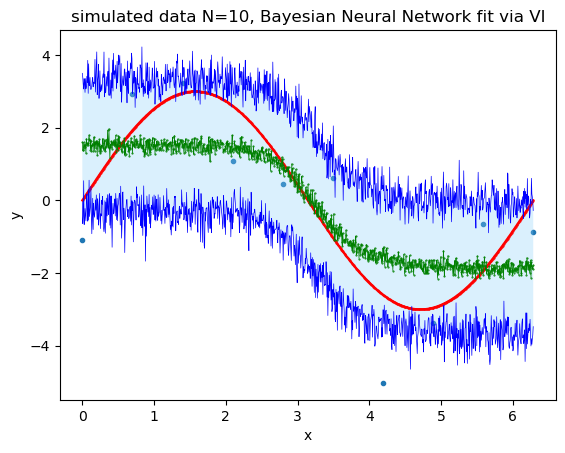

In [139]:
runs = 50
vi2_s_cpd =np.zeros((runs,len(x_0)))
for i in range(runs):
    vi2_s_cpd[i,:]=np.reshape(model_vi2_s.predict(x_0),len(x_0))
    

plot_with_ci_s(estimate = np.mean(vi2_s_cpd, axis=0), 
             lower = np.quantile(vi2_s_cpd, .025, axis=0),
             upper = np.quantile(vi2_s_cpd, .975, axis=0),
             label = 'Bayesian Neural Network fit via VI')

hmm...

## 10. Bayesian Neural Network via MC Dropout

Alternative approach to implement BNN is to use a **Dropout** layer after each layer. 

This approach randomly drops neurons at certain probabilities at each layer, which in effect implements **two-point discrete distributions for each layer's weights** (either zero or some non-zero number at some probability p and 1-p respectively). 

This approach does not necessarily increase the number of parameters from the non-Bayesian version and is relatively easy to implement (one could choose to increase the number of neurons in the dense layers since some of them will be dropped). 

In [140]:
def normal_exp(params): 
    return tfd.Normal(loc=params[:,0:1], 
                      scale=tf.math.exp(params[:,1:2])) # negative input is acceptable

In [141]:
from tensorflow.keras.layers import Dropout

inputs = Input(shape=(1,))
hidden = Dense(10,activation="sigmoid")(inputs)
hidden = Dropout(0.2)(hidden, training=True)
hidden = Dense(20,activation="sigmoid")(hidden)
hidden = Dropout(0.2)(hidden, training=True)
hidden = Dense(6,activation="sigmoid")(hidden)
hidden = Dropout(0.2)(hidden, training=True)
params_mc = Dense(2)(hidden)
dist_mc = tfp.layers.DistributionLambda(normal_exp, name='normal_exp')(params_mc) 

model_mc = Model(inputs=inputs, outputs=dist_mc)
model_mc.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_58 (Dense)             (None, 10)                20        
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 20)                220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 6)                 126       
_________________________________________________________________
dropout_2 (Dropout)          (None, 6)                 0  

In [142]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.004,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True)      
    
model_mc.compile(loss = dist_NLL, 
                 optimizer=keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9))
                 #optimizer=Adam(learning_rate=0.0002)) 

In [143]:
history = model_mc.fit(x_1p, yp, epochs=1500, verbose=0, batch_size=1, validation_split = 0.2)
loss = history.history['loss']
val_loss = history.history['val_loss']

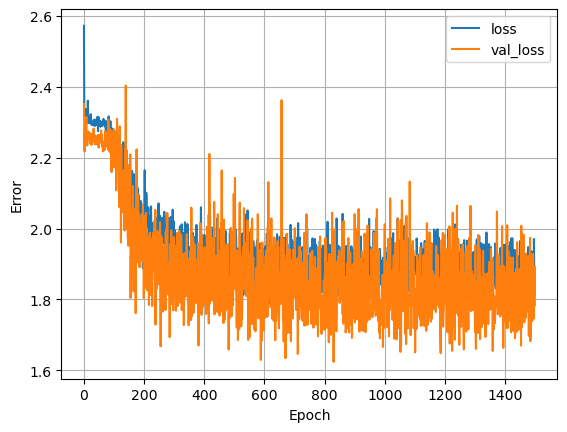

In [144]:
plot_loss(loss, val_loss)

In [145]:
## you can save and load weights
# model_mc.save_weights('model_mc.hdf5')
# model_mc.load_weights("model_mc.hdf5")

In [146]:
runs = 100
mc_cpd =np.zeros((runs,len(x_0)))
for i in range(runs):
    mc_cpd[i,:]=np.reshape(model_mc.predict(x_0),len(x_0))

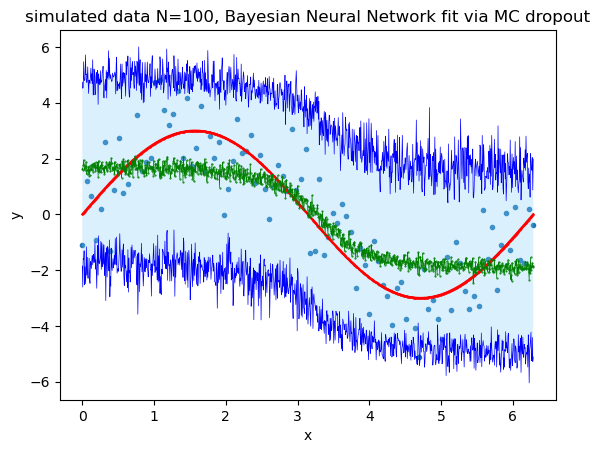

In [147]:
plot_with_ci(estimate = np.mean(mc_cpd, axis=0), 
             lower = np.quantile(mc_cpd, .025, axis=0),
             upper = np.quantile(mc_cpd, .975, axis=0), 
             label = 'Bayesian Neural Network fit via MC dropout')

*Try changing the model structures and optimizers to get a sense of how to train this BNN. To be honest, I don't really understand how to effectively select these and train the model.*  


In theory, one could specify models of Non-Bayesian, BNN-IV, and BNN-MC in parallel structures as follows:
- The BNN-IV model is a simple substitution of Dense to DenseFlipout layers of the Non-Bayesian model
- The BNN-MC model is a simple addition of Dropout layer for each layer of the Non-Bayesian model  
See such an example in `nb_ch08_03` and `nb_ch08_04`. 


### With small sample

In [148]:
inputs = Input(shape=(1,))
hidden = Dense(6,activation="sigmoid")(inputs)
hidden = Dropout(0.2)(hidden, training=True)
hidden = Dense(10,activation="sigmoid")(hidden)
hidden = Dropout(0.2)(hidden, training=True)
# hidden = Dense(6,activation="sigmoid")(hidden)
# hidden = Dropout(0.2)(hidden, training=True)
params_mc = Dense(2)(hidden)
dist_mc = tfp.layers.DistributionLambda(normal_exp, name='normal_exp')(params_mc) 

model_mc_s = Model(inputs=inputs, outputs=dist_mc)
# model_mc_s.summary()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.005,
    decay_steps=1000,
    decay_rate=0.8)      
    
model_mc_s.compile(loss = dist_NLL, 
                # optimizer=keras.optimizers.SGD(learning_rate=lr_schedule))
                 optimizer=Adam(learning_rate=lr_schedule)) 

In [149]:
history = model_mc_s.fit(xs_1p, ysp, epochs=1000, verbose=0, batch_size=1) 
loss = history.history['loss']

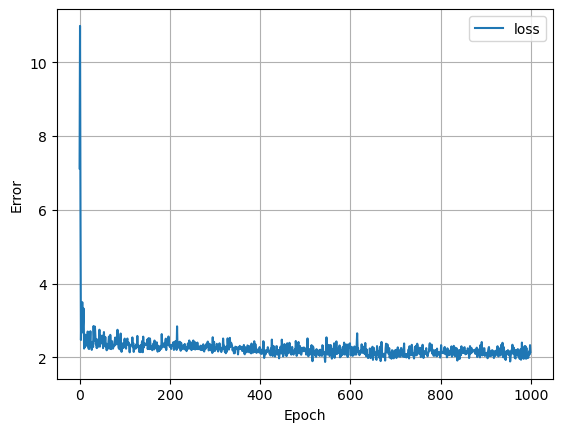

In [150]:
plot_loss(loss)

In [151]:
runs = 50
mc_cpd_s =np.zeros((runs,len(x_0)))
for i in range(runs):
    mc_cpd_s[i,:]=np.reshape(model_mc_s.predict(x_0),len(x_0))

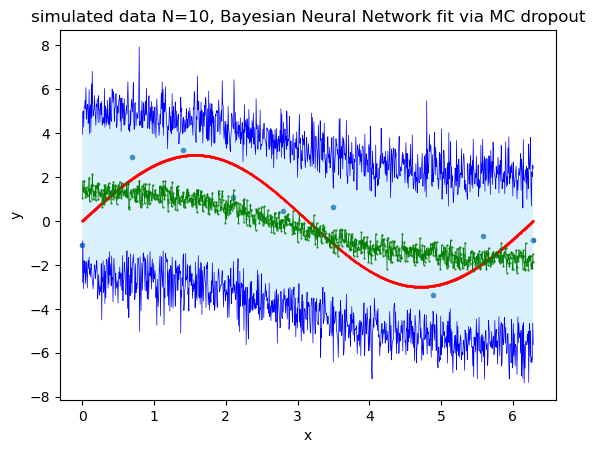

In [152]:
plot_with_ci_s(estimate = np.mean(mc_cpd_s, axis=0), 
             lower = np.quantile(mc_cpd_s, .025, axis=0),
             upper = np.quantile(mc_cpd_s, .975, axis=0), 
             label = 'Bayesian Neural Network fit via MC dropout')

*It appears to show that there is large uncertainty (see the expanded range of vertical axis).*

### 10.2 Training with GradientTape/Eager

In [153]:
l2_reg1 = keras.regularizers.l2(l2=0.002)
l2_reg2 = keras.regularizers.l2(l2=0.002)

# nonlinear conditional mean from x using tanh activation 
inputs = Input(shape=(1,))
hidden1 = keras.layers.Dense(10, activation = 'tanh', kernel_regularizer=l2_reg1)(inputs)
hidden1 = keras.layers.Dropout(.2)(hidden1, training=True)
hidden1 = keras.layers.Dense(20, activation = 'tanh', kernel_regularizer=l2_reg1)(hidden1)
hidden1 = keras.layers.Dropout(.2)(hidden1, training=True)
hidden1 = keras.layers.Dense(10, activation = 'tanh', kernel_regularizer=l2_reg1)(hidden1)
hidden1 = keras.layers.Dropout(.2)(hidden1, training=True)
out1 = keras.layers.Dense(1,  activation='linear', kernel_regularizer=l2_reg1)(hidden1) 

# nonlinear conditional (log of) standard deviation from x using sigmoid activation 
hidden2 = keras.layers.Dense(10, activation = 'sigmoid', kernel_regularizer=l2_reg2)(inputs)
hidden2 = keras.layers.Dropout(.2)(hidden2, training=True)
hidden2 = keras.layers.Dense(20, activation = 'sigmoid', kernel_regularizer=l2_reg2)(hidden2)
hidden2 = keras.layers.Dropout(.2)(hidden2, training=True)
hidden2 = keras.layers.Dense(10, activation = 'sigmoid', kernel_regularizer=l2_reg2)(hidden2)
hidden2 = keras.layers.Dropout(.2)(hidden2, training=True)
out2 = keras.layers.Dense(1, activation='linear', kernel_regularizer=l2_reg2)(hidden2)

params = Concatenate()([out1, out2])
dist = tfp.layers.DistributionLambda(normal_sp)(params) 
model_mc2_out1 = keras.Model(inputs=inputs, outputs=out1)
model_mc2_out2 = keras.Model(inputs=inputs, outputs=out2)
model_mc2 = keras.Model(inputs=inputs, outputs=dist)


# fix the scale parameter till some number of itereations has reached 
len_out2_layers = len(model_mc2_out2.trainable_variables)
len_out2_inputs = len(model_mc2_out2.trainable_variables[len_out2_layers-2].numpy())
model_mc2_out2.trainable_variables[len_out2_layers-1].assign([-10.]) # last layer bias
model_mc2_out2.trainable_variables[len_out2_layers-2].assign(tf.zeros((len_out2_inputs,1))); # last layer weights
         

In [154]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps=2000,
    decay_rate=0.96,
    staircase=True)

tf_step_two_outs_mc2 = gen_eager_step_two_outs(
                            model = model_mc2,
                            model_out1 = model_mc2_out1,
                            model_out2 = model_mc2_out2,
                            loss_fn = dist_NLL,
                            optimizer1 = keras.optimizers.SGD(learning_rate=lr_schedule),
                            optimizer2 = keras.optimizers.Nadam(learning_rate=0.001))

# For the medium ample, use: x_tf, y_tf
eager_train_steps(
    tf_eager_func = tf_step_two_outs_mc2, 
    n_epochs = 2000, 
    x = x_tf,  
    y = y_tf, 
    batch_size = 1, 
    train_out1_start=1, 
    train_out2_start=500, 
    metrics =[keras.metrics.MeanSquaredError()], 
    params_track=[keras.metrics.Mean(name='scale')])

2000/2000 mean_squared_error:3.8958 scale:1.2562


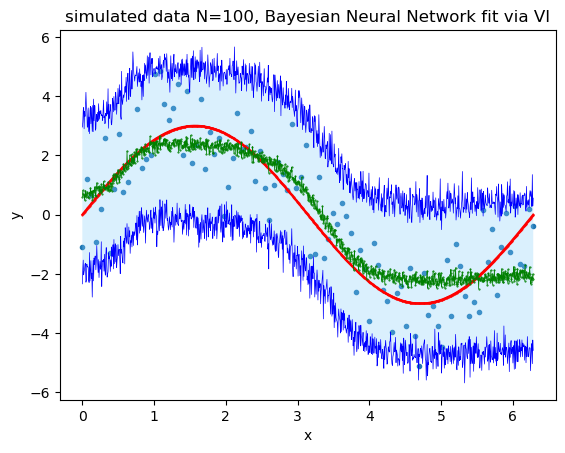

In [155]:
runs = 100
mc2_cpd =np.zeros((runs,len(x_0)))
for i in range(runs):
    mc2_cpd[i,:]=np.reshape(model_mc2.predict(x_0),len(x_0))
    
plot_with_ci(estimate = np.mean(mc2_cpd, axis=0), 
             lower = np.quantile(mc2_cpd, .025, axis=0),
             upper = np.quantile(mc2_cpd, .975, axis=0),
             label = 'Bayesian Neural Network fit via VI')

It appears okay for the 100-point data.

### With Small Sample

In [156]:
l2_reg1 = keras.regularizers.l2(l2=0.002)
l2_reg2 = keras.regularizers.l2(l2=0.002)

# nonlinear conditional mean from x using tanh activation 
inputs = Input(shape=(1,))
hidden1 = keras.layers.Dense(6, activation = 'tanh', kernel_regularizer=l2_reg1)(inputs)
hidden1 = keras.layers.Dropout(.2)(hidden1, training=True)
hidden1 = keras.layers.Dense(10, activation = 'tanh', kernel_regularizer=l2_reg1)(hidden1)
hidden1 = keras.layers.Dropout(.2)(hidden1, training=True)
# hidden1 = keras.layers.Dense(10, activation = 'tanh', kernel_regularizer=l2_reg1)(hidden1)
# hidden1 = keras.layers.Dropout(.2)(hidden1, training=True)
out1 = keras.layers.Dense(1,  activation='linear', kernel_regularizer=l2_reg1)(hidden1) 

# nonlinear conditional (log of) standard deviation from x using sigmoid activation 
hidden2 = keras.layers.Dense(6, activation = 'sigmoid', kernel_regularizer=l2_reg2)(inputs)
hidden2 = keras.layers.Dropout(.2)(hidden2, training=True)
hidden2 = keras.layers.Dense(10, activation = 'sigmoid', kernel_regularizer=l2_reg2)(hidden2)
hidden2 = keras.layers.Dropout(.2)(hidden2, training=True)
# hidden2 = keras.layers.Dense(10, activation = 'sigmoid', kernel_regularizer=l2_reg2)(hidden2)
# hidden2 = keras.layers.Dropout(.2)(hidden2, training=True)
out2 = keras.layers.Dense(1, activation='linear', kernel_regularizer=l2_reg2)(hidden2)

params = Concatenate()([out1, out2])
dist = tfp.layers.DistributionLambda(normal_sp)(params) 
model_mc2_s_out1 = keras.Model(inputs=inputs, outputs=out1)
model_mc2_s_out2 = keras.Model(inputs=inputs, outputs=out2)
model_mc2_s = keras.Model(inputs=inputs, outputs=dist)


# fix the scale parameter till some number of itereations has reached 
len_out2_layers = len(model_mc2_s_out2.trainable_variables)
len_out2_inputs = len(model_mc2_s_out2.trainable_variables[len_out2_layers-2].numpy())
model_mc2_s_out2.trainable_variables[len_out2_layers-1].assign([-10.]) # last layer bias
model_mc2_s_out2.trainable_variables[len_out2_layers-2].assign(tf.zeros((len_out2_inputs,1))); # last layer weights
         

In [157]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.004,
    decay_steps=2000,
    decay_rate=0.96,
    staircase=True)

tf_step_two_outs_mc2s = gen_eager_step_two_outs(
                            model = model_mc2_s,
                            model_out1 = model_mc2_s_out1,
                            model_out2 = model_mc2_s_out2,
                            loss_fn = dist_NLL,
                            optimizer1 = keras.optimizers.SGD(learning_rate=lr_schedule),
                            optimizer2 = keras.optimizers.Nadam(learning_rate=0.001))

# For the small ample, use: xs_tf, ys_tf
eager_train_steps(
    tf_eager_func = tf_step_two_outs_mc2s, 
    n_epochs = 2000, 
    x = xs_tf,  
    y = ys_tf, 
    batch_size = 1, 
    train_out1_start=1, 
    train_out2_start=500, 
    metrics =[keras.metrics.MeanSquaredError()], 
    params_track=[keras.metrics.Mean(name='scale')])

2000/2000 mean_squared_error:1.7379 scale:1.27168


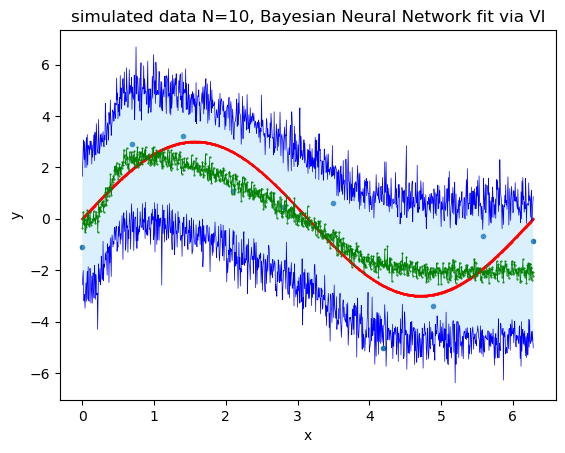

In [158]:
runs = 50
mc2_s_cpd =np.zeros((runs,len(x_0)))
for i in range(runs):
    mc2_s_cpd[i,:]=np.reshape(model_mc2_s.predict(x_0),len(x_0))
    
plot_with_ci_s(estimate = np.mean(mc2_s_cpd, axis=0), 
             lower = np.quantile(mc2_s_cpd, .025, axis=0),
             upper = np.quantile(mc2_s_cpd, .975, axis=0),
             label = 'Bayesian Neural Network fit via VI')

Not bad...

## 11. Revisiting the Maximum likelihood formula with non-constant variance using a Bayesian NN approach 

We will convert the previous model of nonlinear maximum likelihood with non-constant variance into a BNN model. 
This is done by:

- Inserting **Dropout layer** after each layer 
- Making sure the Dropout layers' **training option is set True** (this status is then carried over for testing) 

\# Note: one could also convert it to a BNN-VI model using Flipout layers.


In [159]:
# Need to specify 'training = True' for each dropout layer. To do so, create a model without Sequential(). 

inputs = keras.layers.Input(shape=(1,))
hidden = keras.layers.Dense(10, activation = 'sigmoid')(inputs) 
hidden = keras.layers.Dropout(0.2)(hidden, training = True) # runs both in training and testing:
hidden = keras.layers.Dense(20, activation = 'sigmoid')(inputs) 
hidden = keras.layers.Dropout(0.2)(hidden, training = True)
hidden = keras.layers.Dense(10, activation = 'sigmoid')(inputs) 
hidden = keras.layers.Dropout(0.2)(hidden, training = True)
out= keras.layers.Dense(2, activation='linear')(hidden)
model_ml3_mc = keras.models.Model(inputs =inputs, outputs=out)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.005,
    decay_steps=4000,
    decay_rate=0.96,
    staircase=True)

model_ml3_mc.compile(loss= NLL_loss_sigma,
                  optimizer=keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
#                   optimizer=keras.optimizers.Adam(learning_rate=0.002),
#                   optimizer=keras.optimizers.RMSprop(lr=0.00001),
                  metrics=[NLL_loss_sigma])

In [160]:
history = model_ml3_mc.fit(x_1p, yp, epochs=4000, verbose=0, batch_size=1, validation_split = 0.2)
loss = history.history['loss']
val_loss = history.history['val_loss']

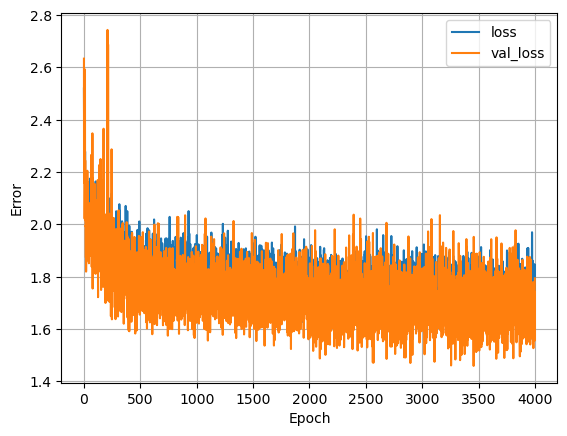

In [161]:
plot_loss(loss, val_loss)

Note that **there is no sign of over-fitting in this case.** 

In [162]:
# even though the weights are all fixed, prediction will vary each time since Dropout layer's training is set True
for i in range(5):
    print(model_ml3_mc.predict(x_0)[0:4][:,0])

[-0.32416666 -0.93555677 -0.3136655  -0.29404414]
[ 2.7273698  -0.32851398 -2.6419091  -3.2254505 ]
[ 0.72825396 -0.32513702 -0.9223708   1.3313128 ]
[-0.3397547 -2.6562862  2.741459  -2.6218143]
[ 0.28457606 -0.3285166   0.30382288  0.31378758]


In [163]:
runs = 200
y_nn_3ml3_mc_cpd = np.zeros((runs,len(x_0)))
pred_log_sigma_mc_cdp = np.zeros((runs,len(x_0)))
for i in range(runs):
    y_nn_3ml3_mc_cpd[i,:]=np.reshape(model_ml3_mc.predict(x_0)[:,0],len(x_0))
    pred_log_sigma_mc_cdp[i,:]=np.reshape(model_ml3_mc.predict(x_0)[:,1],len(x_0))

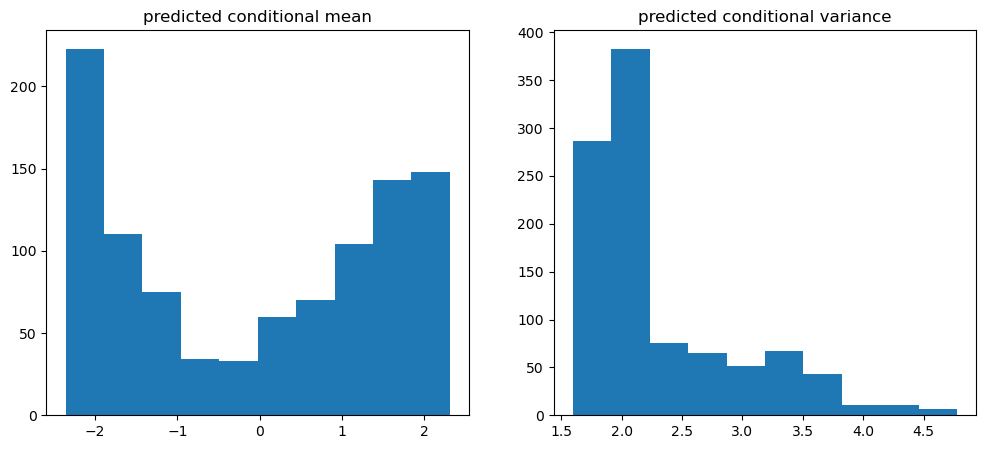

In [164]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(np.mean(y_nn_3ml3_mc_cpd, axis=0))
plt.title('predicted conditional mean')
plt.subplot(1,2,2)
plt.hist(np.mean(np.exp(pred_log_sigma_mc_cdp)**2,axis=0))
plt.title('predicted conditional variance');

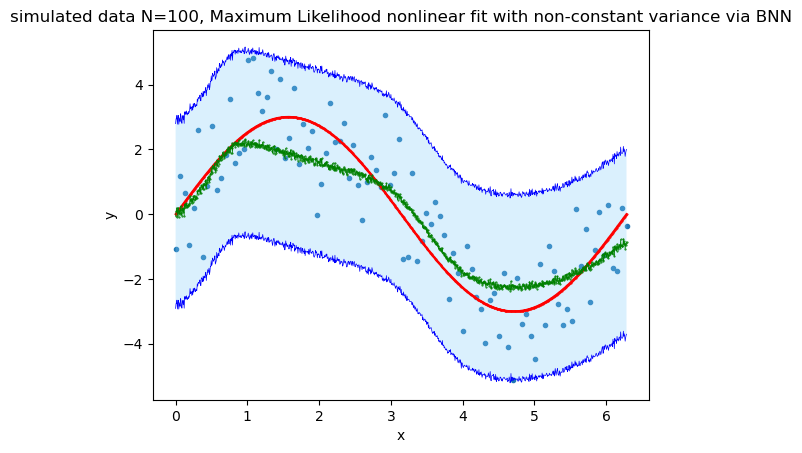

In [165]:
# show the fit plus/minus 2-times the standard deviation 
mc_avg_mean = np.mean(y_nn_3ml3_mc_cpd, axis=0)
mc_avg_sd = np.mean(np.exp(pred_log_sigma_mc_cdp))
plot_with_ci(estimate = mc_avg_mean,
             lower = mc_avg_mean - 2 * mc_avg_sd, 
             upper = mc_avg_mean + 2 * mc_avg_sd, 
             label = 'Maximum Likelihood nonlinear fit with non-constant variance via BNN')

That seems to work.

### With small sample

In [166]:
inputs = keras.layers.Input(shape=(1,))
hidden = keras.layers.Dense(6, activation = 'sigmoid')(inputs) 
hidden = keras.layers.Dropout(0.2)(hidden, training = True) # runs both in training and testing
hidden = keras.layers.Dense(10, activation = 'sigmoid')(hidden) 
hidden = keras.layers.Dropout(0.2)(hidden, training = True)
# hidden = keras.layers.Dense(4, activation = 'sigmoid')(hidden) 
# hidden = keras.layers.Dropout(0.2)(hidden, training = True)
out= keras.layers.Dense(2, activation='linear')(hidden)
model_ml3_s_mc = keras.models.Model(inputs =inputs, outputs=out)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.01,
    decay_steps=2000,
    decay_rate=0.90,
    staircase=True)

model_ml3_s_mc.compile(loss= NLL_loss_sigma,
                  optimizer=keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
#                   optimizer=keras.optimizers.Adam(learning_rate=0.002),
#                   optimizer=keras.optimizers.RMSprop(lr=0.00001),
                  metrics=[NLL_loss_sigma])

In [167]:
history = model_ml3_s_mc.fit(xs_1p, ysp, epochs=2000, verbose=0, batch_size=1) #validation_split = 0.2)
loss = history.history['loss']
# val_loss = history.history['val_loss']

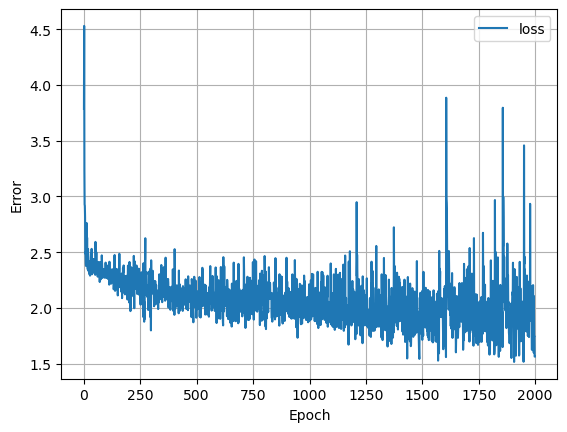

In [168]:
plot_loss(loss)

In [169]:
runs = 100
y_nn_3ml3_s_mc_cpd = np.zeros((runs,len(x_0)))
pred_log_sigma_s_mc_cdp = np.zeros((runs,len(x_0)))
for i in range(runs):
    y_nn_3ml3_s_mc_cpd[i,:]=np.reshape(model_ml3_s_mc.predict(x_0)[:,0],len(x_0))
    pred_log_sigma_s_mc_cdp[i,:]=np.reshape(model_ml3_s_mc.predict(x_0)[:,1],len(x_0))

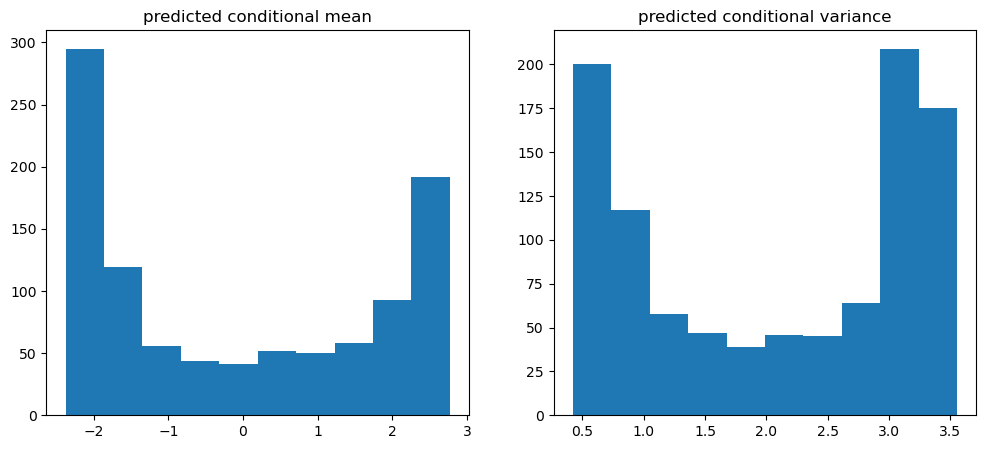

In [170]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(np.mean(y_nn_3ml3_s_mc_cpd, axis=0))
plt.title('predicted conditional mean')
plt.subplot(1,2,2)
plt.hist(np.mean(np.exp(pred_log_sigma_s_mc_cdp)**2,axis=0))
plt.title('predicted conditional variance');

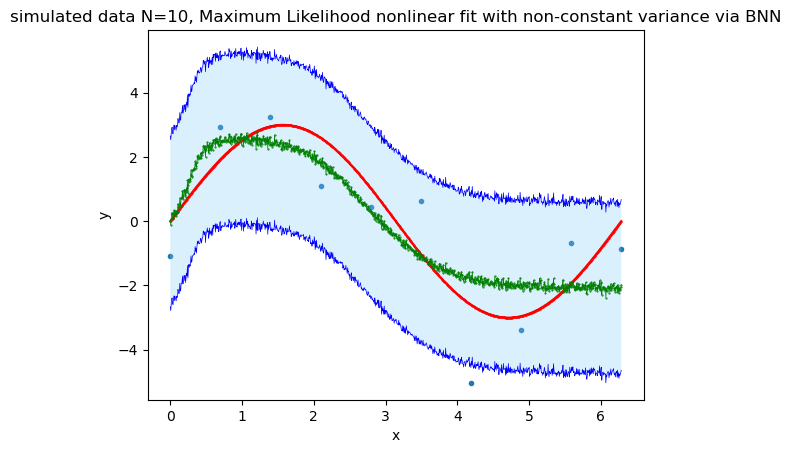

In [171]:
# show the fit plus/minus 2-times the standard deviation 
mc_avg_mean = np.mean(y_nn_3ml3_s_mc_cpd, axis=0)
mc_avg_sd = np.mean(np.exp(pred_log_sigma_s_mc_cdp))
plot_with_ci_s(estimate = mc_avg_mean,
             lower = mc_avg_mean - 2 * mc_avg_sd, 
             upper = mc_avg_mean + 2 * mc_avg_sd, 
             label = 'Maximum Likelihood nonlinear fit with non-constant variance via BNN')

This may show large uncertainty.